<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/AIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install summarytools -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00


In [3]:
!pip install pygwalker -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.2/956.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 23.6 MB/s eta 0:00:00


In [4]:
pip install sweetviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 52.3 MB/s eta 0:00:00


In [5]:
import pygwalker as pyg
from summarytools import dfSummary # module pandas-profiling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv # Module pour faire le rapport HTML
import missingno as msno # observer les données manquantes
from google.colab import files # Exporter en cvs

import numpy as np
from scipy import stats #
import statsmodels.api as sm #
from statsmodels.formula.api import ols #

In [6]:
# Charger le fichier CSV en conservant les titres des colonnes
AIH= pd.read_csv("/content/AIH_2024.csv",sep= ";")


<Axes: >

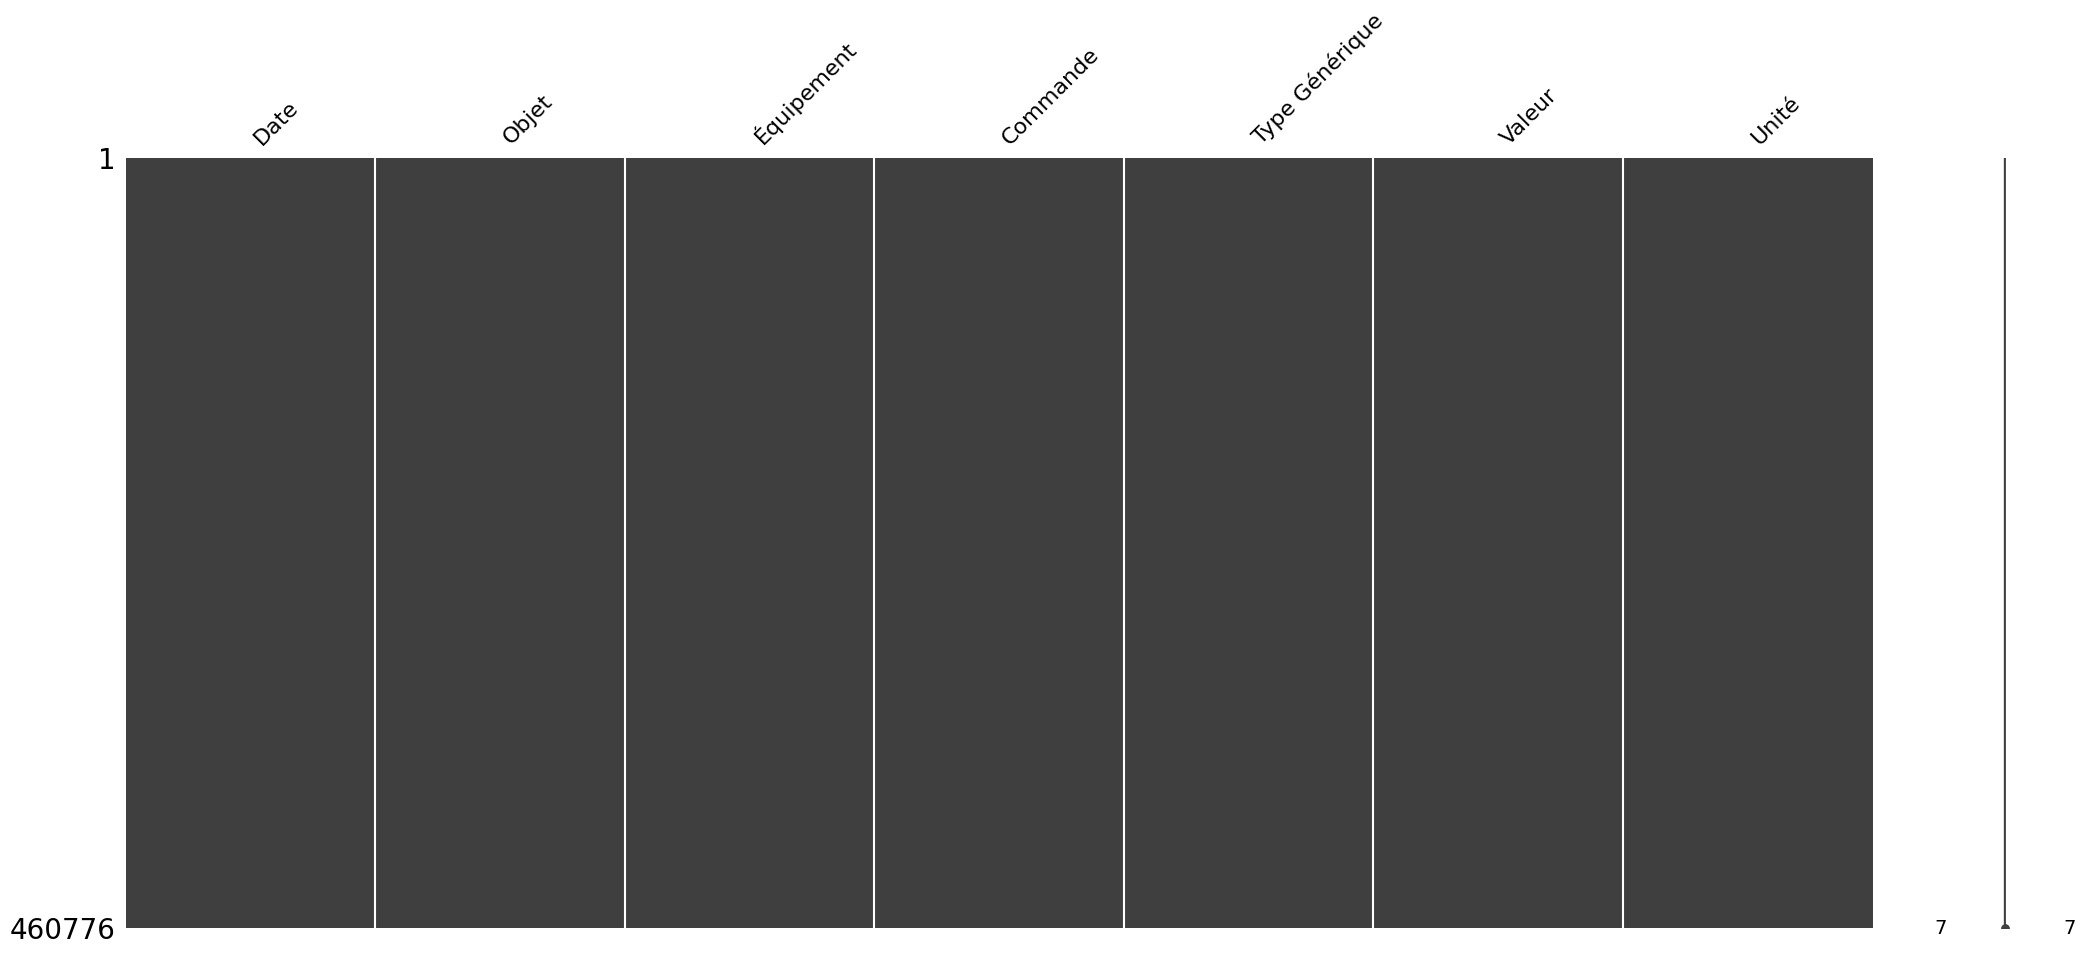

In [7]:
#msno.matrix(AIH)

In [8]:
# Description pour comprendre les données et mettre en suite le tableau en forme
#dfSummary(AIH)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2020-08-07 16:40:002. 2021-12-06 14:57:053. 2020-08-07 16:45:004. 2022-09-15 11:00:005. 2021-12-06 14:57:046. 2021-06-05 11:00:007. 2023-08-06 10:00:008. 2023-01-31 13:05:009. 2021-06-01 19:00:0010. 2022-11-21 12:00:0011. other,"6 (0.0%)5 (0.0%)4 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)460,740 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Objet[object],1. Sonde,"460,776 (100.0%)",,0(0.0%)
3,Équipement[object],1. Sonde_A16_SE_892. Sonde_A14_SE_873. Sonde_A13_SW_864. Sonde_A17_SW_805. Sonde_A01_SW_746. Sonde_A08_SW_717. Sonde_D23_SW_968. J6_Sonde extérieure Bat D9. Sonde_A11_SW_8410. Sonde_D25_S+W_9811. other,"49,219 (10.7%)47,767 (10.4%)46,846 (10.2%)46,768 (10.1%)42,019 (9.1%)41,624 (9.0%)40,782 (8.9%)34,567 (7.5%)33,327 (7.2%)28,365 (6.2%)49,492 (10.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD80lEQVR4nO3dQWojRwCG0VIQQ2YjYQw+jA+Rw+YQuo0x1iIzzEZZZBtlurrEF/C8t7fQ4qNEN/27D7fbbUDht//7C/DrEBsZsZERGxmxkREbGbGRERsZsZE5jDG+jjG+LH7Oj9vt9u0B34dP7Pj8/PzH6XR6WvmQ6/X6fjgc/hQc/+V4Op2eXl9fv53P5+97PuDj4+P3y+Xy9Pb29mWMITbuOo4xxvl8/v7y8vLXwud8fdD34RNzgUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSOY/zzTNreD1j5W34tx+v1+n65XJ7GwjNp1+v1fYzx43Ffi8/IBoHMwb/MovKIk82pxibL6yrLKrZaWldZVjHjEesqyyo2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNLgxdiFGcuDF2MXtvJYOBmDFzJONjIGL2QMXsgYvJBxU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyHgsnY/BCxgUCGT+jZKyryFhXkbGuIuMCgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjIeCydjXUVm5WRzojFl9+DF0IVZuwYvhi7ssTJ4MXRhipu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZHYNXgxd2GP34MXQhVkeCydj8ELGyUbG4IWMwQsZgxcybuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kPFYOBmDFzJ7TjYnGrtMD14MXdhravBi6MKKPYMXQxd2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNTgxdCFFdODF0MX9vJYOBmDFzIuEMjM/oz6CWW3qXWVZRUrNq+rLKtYNbuusqxiNxcIZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDavqyyrWDW1rrKsYoXHwslYV5GZOdmcaizZPHgxdmHVpsGLsQuPMDN4MXZhiZu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDYNXoxdeITNgxdjF1Z5LJyMwQuZPS9K+zdOPX5q6g0v9xjDsMXmN7zcYwzDVrNveLnHGIafclOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOY3vNxjDMNWU294uccYhi08Fk7G4IWMCwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJ/A5lrTuIhgNUFAAAAAElFTkSuQmCC"">",0(0.0%)
4,Commande[object],1. Température2. Température 4,"399,307 (86.7%)61,469 (13.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG9

- Enlever la colonne " Type Générique", car l'ensemble des valeurs = "Temperature".

- Enlever la colonne " Objet", car l'ensemble des valeurs = "Sonde".

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

In [9]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
AIH[['date', 'time']] = AIH['Date'].str.split(' ', expand=True)

# Convertir les nouvelles colonnes au format datetime
AIH['date'] = pd.to_datetime(AIH['date'], format='%Y-%m-%d')
AIH['time'] = pd.to_datetime(AIH['time'], format='%H:%M:%S').dt.time

# Supprimer l'ancienne colonne si elle n'est plus nécessaire
AIH= AIH.drop(columns=['Objet'])

In [10]:
# Fonction de nettoyage
def nettoyer_equipement(data):
    if data.startswith('Sonde'):
        # Séparer les parties par "_"
        parts = data.split('_')
        return parts[0], parts[1], parts[2], parts[3] if len(parts) > 3 else None
    elif data.startswith('J'):
        # Séparer les parties par espace pour traiter les cas "J2_Sonde extérieure  Bat A1"
        parts = data.split(' ', 2)
        return parts[0], parts[1] if len(parts) > 1 else None, None, parts[2] if len(parts) > 2 else None
    return None, None, None, None

# Appliquer la fonction à la colonne 'Equipement' et créer les nouvelles colonnes
AIH[['Type', 'Numéro', 'Orientation', 'Réplicat']] = AIH['Équipement'].apply(
    lambda x: pd.Series(nettoyer_equipement(x))
)

In [11]:
# Description pour comprendre les données et mettre en suite le tableau en forme
#dfSummary(AIH)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2020-08-07 16:40:002. 2021-12-06 14:57:053. 2020-08-07 16:45:004. 2022-09-15 11:00:005. 2021-12-06 14:57:046. 2021-06-05 11:00:007. 2023-08-06 10:00:008. 2023-01-31 13:05:009. 2021-06-01 19:00:0010. 2022-11-21 12:00:0011. other,"6 (0.0%)5 (0.0%)4 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)460,740 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. Sonde_A16_SE_892. Sonde_A14_SE_873. Sonde_A13_SW_864. Sonde_A17_SW_805. Sonde_A01_SW_746. Sonde_A08_SW_717. Sonde_D23_SW_968. J6_Sonde extérieure Bat D9. Sonde_A11_SW_8410. Sonde_D25_S+W_9811. other,"49,219 (10.7%)47,767 (10.4%)46,846 (10.2%)46,768 (10.1%)42,019 (9.1%)41,624 (9.0%)40,782 (8.9%)34,567 (7.5%)33,327 (7.2%)28,365 (6.2%)49,492 (10.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD80lEQVR4nO3dQWojRwCG0VIQQ2YjYQw+jA+Rw+YQuo0x1iIzzEZZZBtlurrEF/C8t7fQ4qNEN/27D7fbbUDht//7C/DrEBsZsZERGxmxkREbGbGRERsZsZE5jDG+jjG+LH7Oj9vt9u0B34dP7Pj8/PzH6XR6WvmQ6/X6fjgc/hQc/+V4Op2eXl9fv53P5+97PuDj4+P3y+Xy9Pb29mWMITbuOo4xxvl8/v7y8vLXwud8fdD34RNzgUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSOY/zzTNreD1j5W34tx+v1+n65XJ7GwjNp1+v1fYzx43Ffi8/IBoHMwb/MovKIk82pxibL6yrLKrZaWldZVjHjEesqyyo2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNLgxdiFGcuDF2MXtvJYOBmDFzJONjIGL2QMXsgYvJBxU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyHgsnY/BCxgUCGT+jZKyryFhXkbGuIuMCgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjIeCydjXUVm5WRzojFl9+DF0IVZuwYvhi7ssTJ4MXRhipu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZHYNXgxd2GP34MXQhVkeCydj8ELGyUbG4IWMwQsZgxcybuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kPFYOBmDFzJ7TjYnGrtMD14MXdhravBi6MKKPYMXQxd2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNTgxdCFFdODF0MX9vJYOBmDFzIuEMjM/oz6CWW3qXWVZRUrNq+rLKtYNbuusqxiNxcIZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDavqyyrWDW1rrKsYoXHwslYV5GZOdmcaizZPHgxdmHVpsGLsQuPMDN4MXZhiZu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDYNXoxdeITNgxdjF1Z5LJyMwQuZPS9K+zdOPX5q6g0v9xjDsMXmN7zcYwzDVrNveLnHGIafclOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOY3vNxjDMNWU294uccYhi08Fk7G4IWMCwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJ/A5lrTuIhgNUFAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. Température2. Température 4,"399,307 (86.7%)61,469 (13.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElE

In [12]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Type'].unique()

# Afficher les modalités
print(modalites)

['Sonde' 'J2_Sonde' 'J6_Sonde']


In [13]:
# Fonction pour nettoyer la colonne 'Type' et extraire 'Numéro'
def nettoyer_type_et_numero(row):
    if row['Type'].startswith('J'):
        numero, type_equipement = row['Type'].split('_', 1)
        return type_equipement, numero
    return row['Type'], row['Numéro']

# Appliquer la fonction pour mettre à jour 'Type' et 'Numéro'
AIH[['Type', 'Numéro']] = AIH.apply(
    lambda row: pd.Series(nettoyer_type_et_numero(row)), axis=1
)

In [14]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Numéro'].unique()

# Afficher les modalités
print(modalites)

['A08' 'A01' 'A03' 'A17' 'A11' 'A13' 'A14' 'D23' 'A16' 'D25' 'J2' 'J6']


In [15]:
# Fonction de nettoyage
def nettoyer_type(data):
    if data.startswith('Sonde'):
        return 'Sonde Intérieur'
    elif data.startswith('J'):
        return 'Sonde Extérieur'
    return data

# Appliquer la fonction de nettoyage à la colonne 'Objets'
AIH['Type'] = AIH['Équipement'].apply(nettoyer_type)


In [16]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Orientation'].unique()

# Afficher les modalités
print(modalites)

['SW' 'SE' 'S+W' None]


In [17]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Réplicat'].unique()

# Afficher les modalités
print(modalites)

['71' '74' '76' '80' '84' '86' '87' '96' '89' '98' ' Bat A1' ' Bat D']


In [18]:
# Fonction pour déplacer les valeurs "Bat A1" et "Bat D" vers la colonne Orientation
def déplacer_bat_vers_orientation(row):
    if 'Bat' in row['Réplicat']:
        # Si la valeur dans 'Réplicat' contient "Bat", déplacez-la dans 'Orientation'
        row['Orientation'] = row['Réplicat'] if pd.notna(row['Orientation']) else row['Réplicat']
    return row

# Appliquer la fonction à chaque ligne du DataFrame
AIH = AIH.apply(déplacer_bat_vers_orientation, axis=1)


Verification du nombre de valeur NA

In [19]:
print(AIH.isna().sum())

Date              0
Équipement        0
Commande          0
Type Générique    0
Valeur            0
Unité             0
date              0
time              0
Type              0
Numéro            0
Orientation       0
Réplicat          0
dtype: int64


<Axes: >

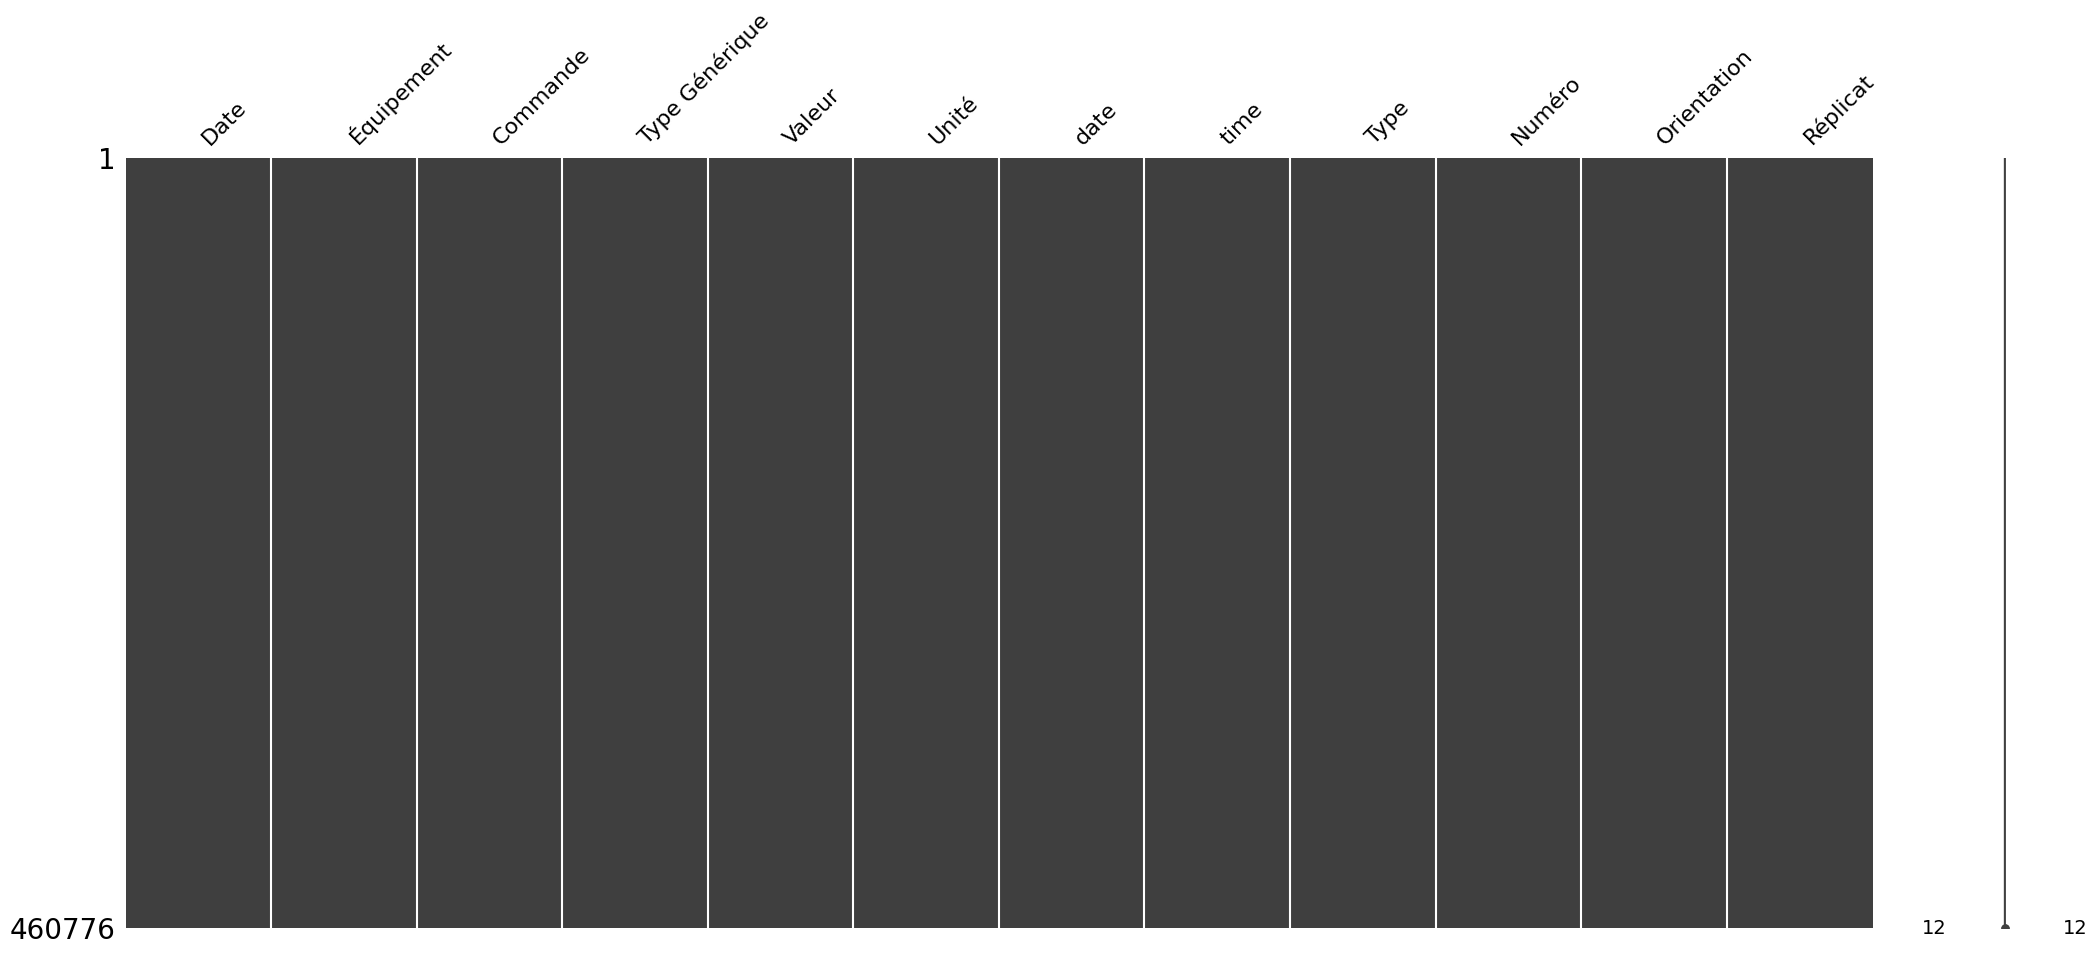

In [20]:
#msno.matrix(AIH)

In [21]:
# Description pour comprendre les données et mettre en suite le tableau en forme
#dfSummary(AIH)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2020-08-07 16:40:002. 2021-12-06 14:57:053. 2020-08-07 16:45:004. 2022-09-15 11:00:005. 2021-12-06 14:57:046. 2021-06-05 11:00:007. 2023-08-06 10:00:008. 2023-01-31 13:05:009. 2021-06-01 19:00:0010. 2022-11-21 12:00:0011. other,"6 (0.0%)5 (0.0%)4 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)460,740 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. Sonde_A16_SE_892. Sonde_A14_SE_873. Sonde_A13_SW_864. Sonde_A17_SW_805. Sonde_A01_SW_746. Sonde_A08_SW_717. Sonde_D23_SW_968. J6_Sonde extérieure Bat D9. Sonde_A11_SW_8410. Sonde_D25_S+W_9811. other,"49,219 (10.7%)47,767 (10.4%)46,846 (10.2%)46,768 (10.1%)42,019 (9.1%)41,624 (9.0%)40,782 (8.9%)34,567 (7.5%)33,327 (7.2%)28,365 (6.2%)49,492 (10.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD80lEQVR4nO3dQWojRwCG0VIQQ2YjYQw+jA+Rw+YQuo0x1iIzzEZZZBtlurrEF/C8t7fQ4qNEN/27D7fbbUDht//7C/DrEBsZsZERGxmxkREbGbGRERsZsZE5jDG+jjG+LH7Oj9vt9u0B34dP7Pj8/PzH6XR6WvmQ6/X6fjgc/hQc/+V4Op2eXl9fv53P5+97PuDj4+P3y+Xy9Pb29mWMITbuOo4xxvl8/v7y8vLXwud8fdD34RNzgUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSOY/zzTNreD1j5W34tx+v1+n65XJ7GwjNp1+v1fYzx43Ffi8/IBoHMwb/MovKIk82pxibL6yrLKrZaWldZVjHjEesqyyo2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNLgxdiFGcuDF2MXtvJYOBmDFzJONjIGL2QMXsgYvJBxU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyHgsnY/BCxgUCGT+jZKyryFhXkbGuIuMCgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjIeCydjXUVm5WRzojFl9+DF0IVZuwYvhi7ssTJ4MXRhipu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZHYNXgxd2GP34MXQhVkeCydj8ELGyUbG4IWMwQsZgxcybuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kPFYOBmDFzJ7TjYnGrtMD14MXdhravBi6MKKPYMXQxd2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNTgxdCFFdODF0MX9vJYOBmDFzIuEMjM/oz6CWW3qXWVZRUrNq+rLKtYNbuusqxiNxcIZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDavqyyrWDW1rrKsYoXHwslYV5GZOdmcaizZPHgxdmHVpsGLsQuPMDN4MXZhiZu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDYNXoxdeITNgxdjF1Z5LJyMwQuZPS9K+zdOPX5q6g0v9xjDsMXmN7zcYwzDVrNveLnHGIafclOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOY3vNxjDMNWU294uccYhi08Fk7G4IWMCwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJ/A5lrTuIhgNUFAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. Température2. Température 4,"399,307 (86.7%)61,469 (13.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElE

Enlever la colonne " Type Générique"

In [59]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
AIH= AIH.drop(columns=['Type Générique'])

KeyError: "['Type Générique'] not found in axis"

In [ ]:
Rajouter des colonnes pour faciliter la création des Graphiques et des analyses :

In [56]:
# Assurez-vous que la colonne 'Date' est bien au format datetime
AIH['Date'] = pd.to_datetime(AIH['Date'])

In [24]:
# Ajouter une colonne 'Mois' pour extraire le mois (1-12)
AIH['Mois'] = AIH['Date'].dt.month

In [25]:
# Ajouter une colonne 'Semaine' pour extraire la semaine de l'année
AIH['Semaine'] = AIH['Date'].dt.isocalendar().week

In [26]:
# Créer une colonne 'Année' si elle n'existe pas déjà
AIH['annee'] = AIH['Date'].dt.year

In [64]:
# Ajouter une colonne 'Jour/Nuit' basée sur l'heure
AIH['Jour/Nuit'] = np.where(
    (AIH['time'] >= '20:00:00') | (AIH['time'] < '08:00:00'),
    'Nuit',
    'Jour'
)


TypeError: '>=' not supported between instances of 'datetime.time' and 'str'

In [67]:
# Ajouter une colonne 'Ete/Hiver' basée sur le mois (valeurs numériques)
AIH['Ete/Hiver'] = np.where(
    (AIH['Mois'] >= 5) & (AIH['Mois'] <= 9),  # Mois de mai (5) à septembre (9) inclus
    'Ete',  # Été
    'Hiver'  # Hiver
)


In [30]:
AIH['Valeur'] = pd.to_numeric(AIH['Valeur'].str.replace(',', '.'), errors='coerce')

In [62]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
AIH= AIH.drop(columns=['Équipement'])

In [68]:
AIH

,Date,Commande,Valeur,Unité,date,time,Type,Numéro,Orientation,Réplicat,Mois,Semaine,annee,Jour/Nuit,Ete/Hiver
0,2020-08-07 16:40:00,Température,26.51,°C,2020-08-07,16:40:00,Sonde Intérieur,A08,SW,71,8,32,2020,Jour,Ete
1,2020-08-07 16:50:00,Température,26.51,°C,2020-08-07,16:50:00,Sonde Intérieur,A08,SW,71,8,32,2020,Jour,Ete
2,2020-08-07 16:56:16,Température,26.51,°C,2020-08-07,16:56:16,Sonde Intérieur,A08,SW,71,8,32,2020,Jour,Ete
3,2020-08-07 20:28:03,Température,26.35,°C,2020-08-07,20:28:03,Sonde Intérieur,A08,SW,71,8,32,2020,Nuit,Ete
4,2020-08-07 21:22:35,Température,26.20,°C,2020-08-07,21:22:35,Sonde Intérieur,A08,SW,71,8,32,2020,Nuit,Ete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460771,2024-10-10 11:45:00,Température 4,15.60,°C,2024-10-10,11:45:00,Sonde Extérieur,J6,Bat D,Bat D,10,41,2024,Jour,Hiver
460772,2024-10-10 11:50:00,Température 4,15.50,°C,2024-10-10,11:50:00,Sonde Extérieur,J6,Bat D,Bat D,10,41,2024,Jour,Hiver
460773,2024-10-10 11:55:00,Température 4,15.50,°C,2024-10-10,11:55:00,Sonde Extérieur,J6,Bat D,Bat D,10,41,2024,Jour,Hiver
460774,2024-10-10 12:00:00,Température 4,15.35,°C,2024-10-10,12:00:00,Sonde Extérieur,J6,Bat D,Bat D,10,41,2024,Jour,Hiver


Rapport des données nettoyées :

In [27]:
#my_report = sv.analyze(AIH)

In [28]:
#my_report.show_html()

Rapport des données de AIH, binaire entre les SONDES extérieurs et intérieurs

In [31]:
#my_report = sv.compare_intra(AIH, AIH["Type"] == "Sonde Intérieur", ["Sonde Intérieur", "Sonde Extérieur"])

In [32]:
#my_report.show_html()

In [33]:

# Sauvegarder le DataFrame en tant que fichier CSV
#AIH.to_csv('AIH_export.csv', index=False)

# Télécharger le fichier dans votre machine locale
#files.download('AIH_export.csv')

Graphiques :

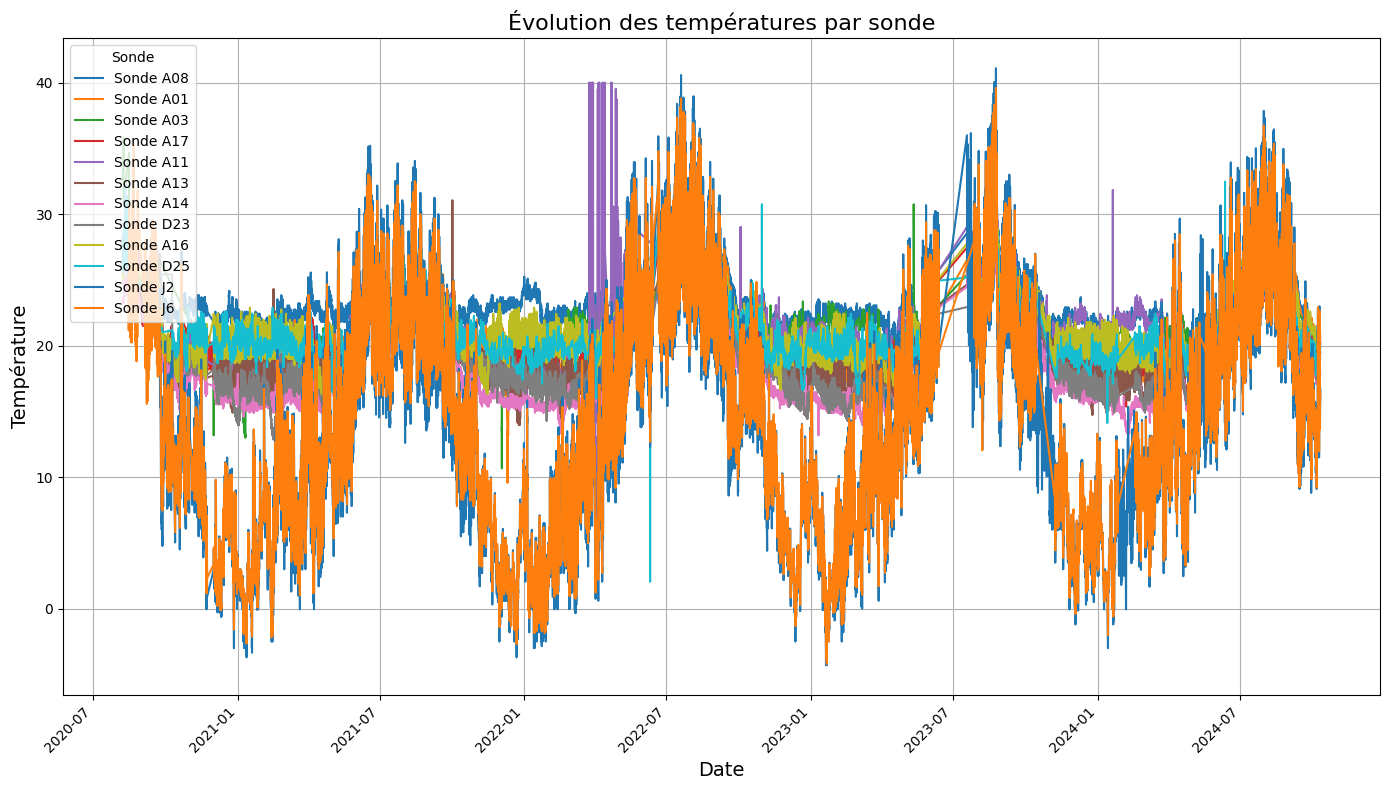

In [34]:
# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer une courbe pour chaque sonde
for sonde in AIH['Numéro'].unique():
    # Filtrer les données pour chaque sonde
    sonde_data = AIH[AIH['Numéro'] == sonde]
    plt.plot(sonde_data['Date'], sonde_data['Valeur'], label=f"Sonde {sonde}")

# Ajouter des labels et une légende
plt.title("Évolution des températures par sonde", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Température", fontsize=14)
plt.legend(title="Sonde", loc='upper left', fontsize=10)
plt.grid(True)

# Ajuster les dates pour qu'elles soient lisibles
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()


Pouvez vous certifier que la sonde A11 n'a pas eu de probleme en 2022 en Mars / Avril 2022, car nous avons des temperatures de 40 °C en "hiver".

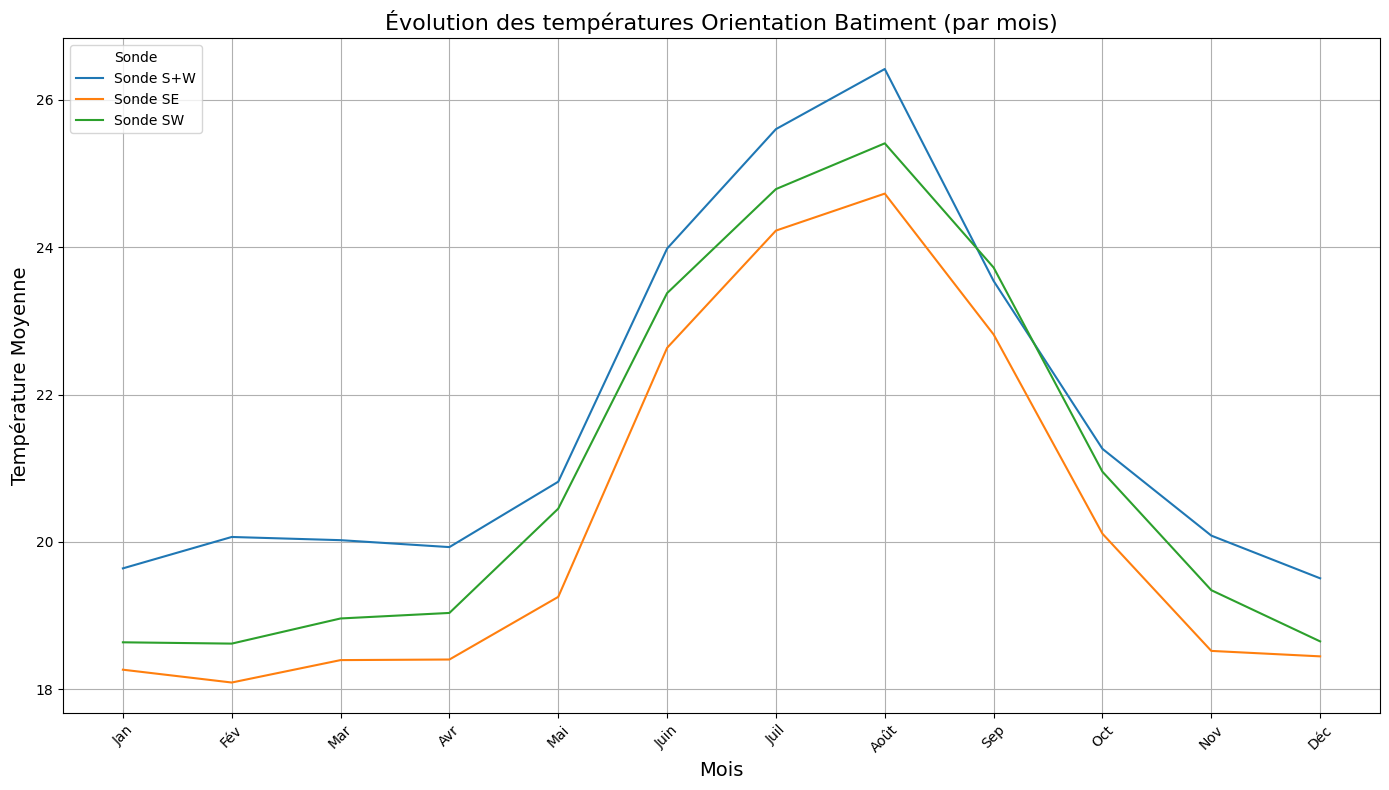

In [35]:
# Filtrer les données pour exclure les sondes J2 et J6
AIH_filtered = AIH[~AIH['Type'].isin([ 'Sonde Extérieur'])]
# Regrouper les données par mois pour calculer les moyennes mensuelles
moyennes_mensuelles = AIH_filtered.groupby(['Mois', 'Orientation'])['Valeur'].mean().reset_index()

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer une courbe pour chaque sonde
for sonde in moyennes_mensuelles['Orientation'].unique():
    sonde_data = moyennes_mensuelles[moyennes_mensuelles['Orientation'] == sonde]
    plt.plot(sonde_data['Mois'], sonde_data['Valeur'], label=f"Sonde {sonde}")

# Ajouter des labels et une légende
plt.title("Évolution des températures Orientation Batiment (par mois)", fontsize=16)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Température Moyenne", fontsize=14)
plt.xticks(range(1, 13), [
    'Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin',
    'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'
], rotation=45)
plt.legend(title="Sonde", loc='upper left', fontsize=10)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()


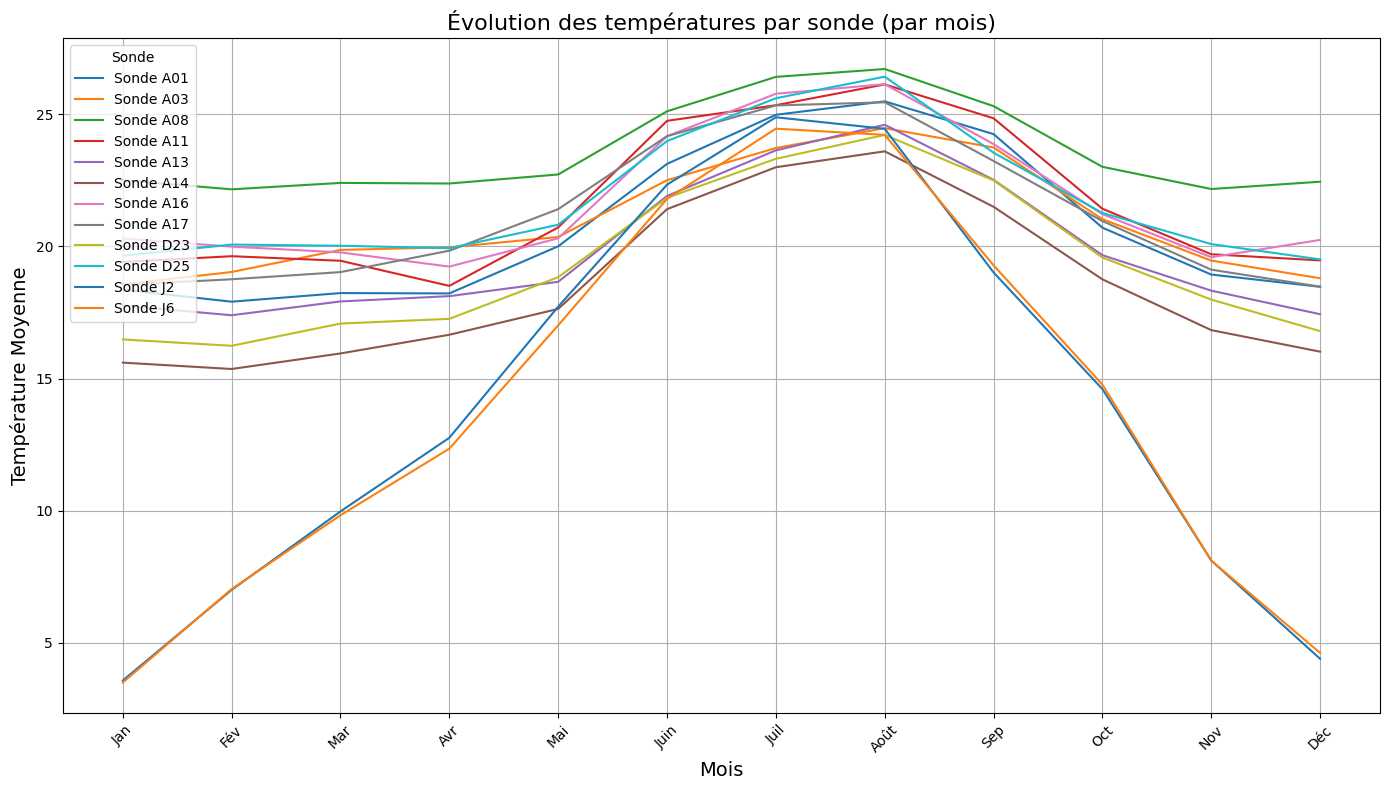

In [36]:
# Regrouper les données par mois pour calculer les moyennes mensuelles
moyennes_mensuelles = AIH.groupby(['Mois', 'Numéro'])['Valeur'].mean().reset_index()

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer une courbe pour chaque sonde
for sonde in moyennes_mensuelles['Numéro'].unique():
    sonde_data = moyennes_mensuelles[moyennes_mensuelles['Numéro'] == sonde]
    plt.plot(sonde_data['Mois'], sonde_data['Valeur'], label=f"Sonde {sonde}")

# Ajouter des labels et une légende
plt.title("Évolution des températures par sonde (par mois)", fontsize=16)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Température Moyenne", fontsize=14)
plt.xticks(range(1, 13), [
    'Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin',
    'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'
], rotation=45)
plt.legend(title="Sonde", loc='upper left', fontsize=10)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()


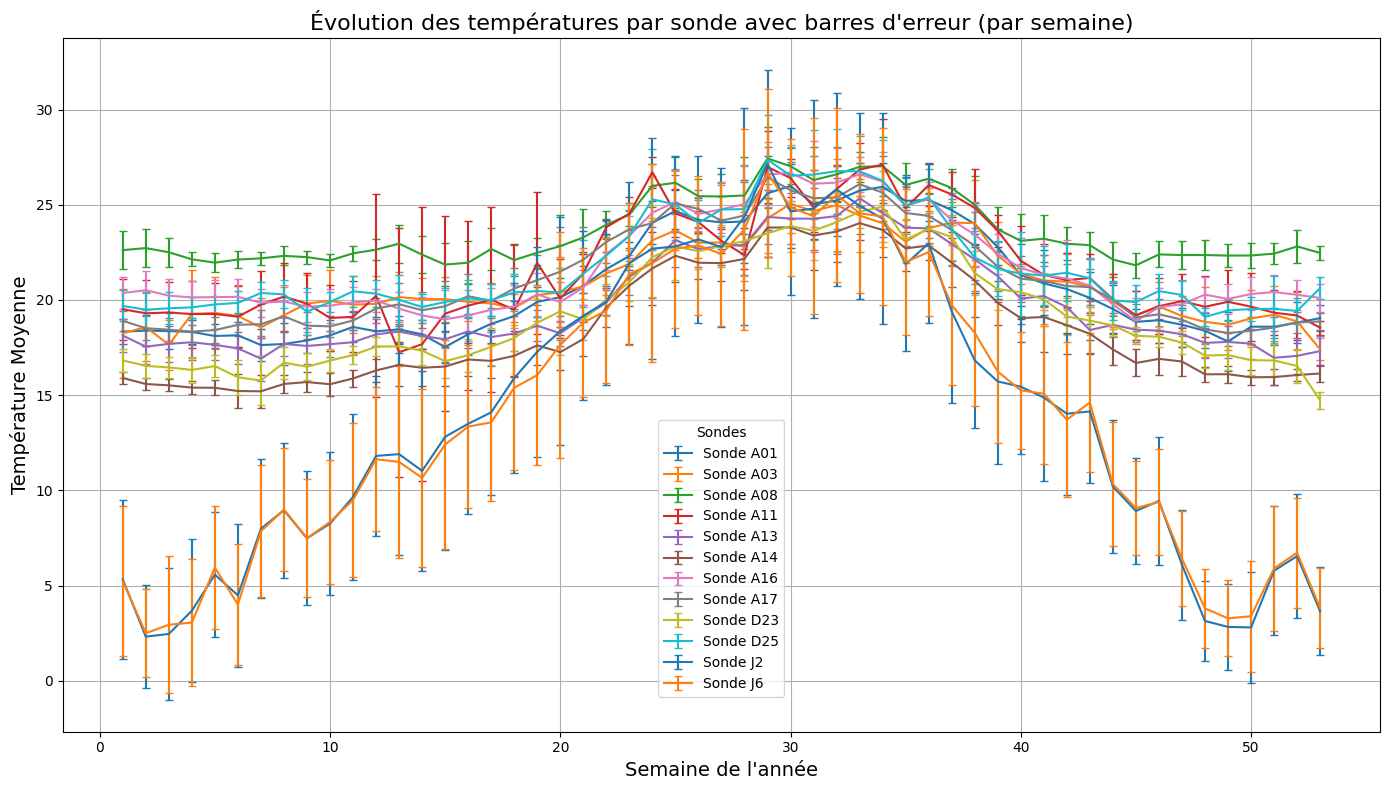

In [37]:
# Calculer la moyenne et l'écart-type par semaine et par sonde
stats_semaine = AIH.groupby(['Semaine', 'Numéro'])['Valeur'].agg(['mean', 'std']).reset_index()

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer les courbes avec barres d'erreur
for sonde in stats_semaine['Numéro'].unique():
    sonde_data = stats_semaine[stats_semaine['Numéro'] == sonde]
    plt.errorbar(
        sonde_data['Semaine'],
        sonde_data['mean'],
        yerr=sonde_data['std'],
        label=f"Sonde {sonde}",
        capsize=3
    )

# Ajouter des labels
plt.title("Évolution des températures par sonde avec barres d'erreur (par semaine)", fontsize=16)
plt.xlabel("Semaine de l'année", fontsize=14)
plt.ylabel("Température Moyenne", fontsize=14)

# Positionner la légende au centre en bas
plt.legend(title="Sondes", loc='center', bbox_to_anchor=(0.5, 0.25), fontsize=10)

# Ajouter une grille
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()

<ipython-input-38-9c02d881e0c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIH_filtered['Date'] = pd.to_datetime(AIH_filtered['Date'])
<ipython-input-38-9c02d881e0c7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIH_filtered['Semaine'] = AIH_filtered['Date'].dt.isocalendar().week


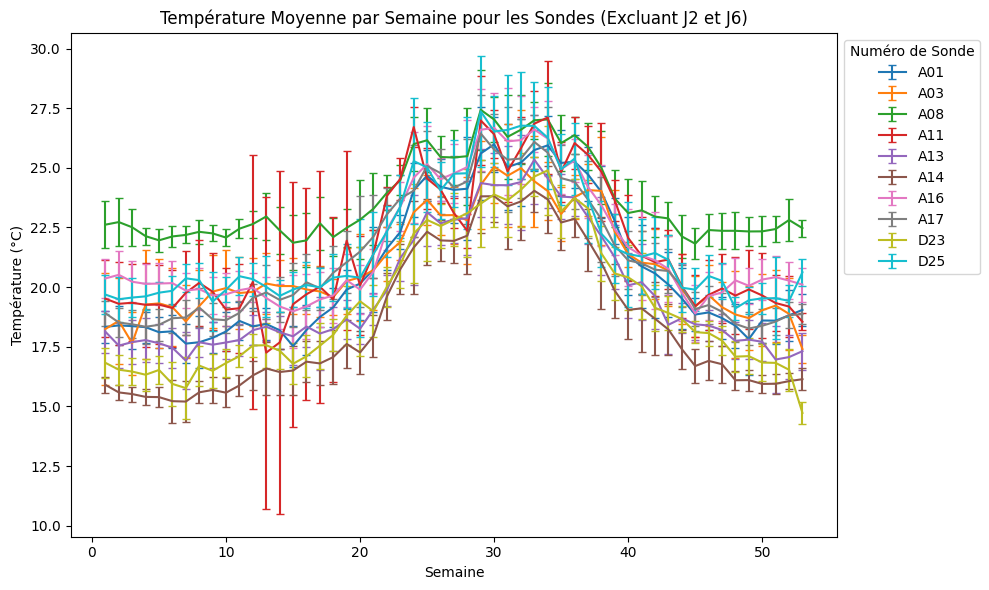

In [38]:

# Filtrer les données pour exclure les sondes J2 et J6
AIH_filtered = AIH[~AIH['Type'].isin([ 'Sonde Extérieur'])]

# Convertir la colonne 'Date' en format datetime si nécessaire
AIH_filtered['Date'] = pd.to_datetime(AIH_filtered['Date'])

# Calculer la moyenne et l'écart-type par semaine
AIH_filtered['Semaine'] = AIH_filtered['Date'].dt.isocalendar().week
AIH_filtered_grouped = AIH_filtered.groupby(['Semaine', 'Numéro']).agg(
    moyenne_temp=('Valeur', 'mean'),
    std_temp=('Valeur', 'std')
).reset_index()

# Tracer le graphique
plt.figure(figsize=(10, 6))
for sonde in AIH_filtered_grouped['Numéro'].unique():
    data = AIH_filtered_grouped[AIH_filtered_grouped['Numéro'] == sonde]
    plt.errorbar(data['Semaine'], data['moyenne_temp'], yerr=data['std_temp'], label=sonde, capsize=3)

# Ajouter des labels et une légende
plt.title('Température Moyenne par Semaine pour les Sondes (Excluant J2 et J6)')
plt.xlabel('Semaine')
plt.ylabel('Température (°C)')
plt.legend(title='Numéro de Sonde', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


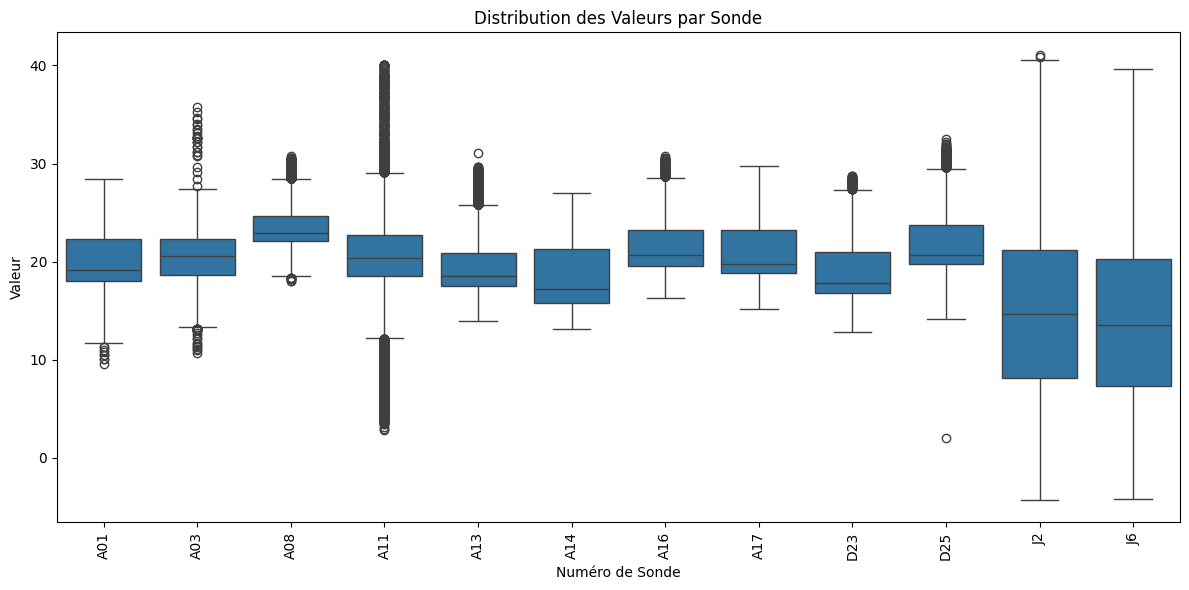

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que 'Numéro' est bien une colonne catégorielle
AIH['Numéro'] = AIH['Numéro'].astype('category')

# Créer le graphique boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Numéro', y='Valeur', data=AIH)

# Ajouter un titre et des labels
plt.title('Distribution des Valeurs par Sonde')
plt.xlabel('Numéro de Sonde')
plt.ylabel('Valeur')

# Afficher le graphique
plt.xticks(rotation=90)  # Pour faire pivoter les étiquettes des sondes si elles sont longues
plt.tight_layout()  # Pour ajuster les éléments du graphique
plt.show()


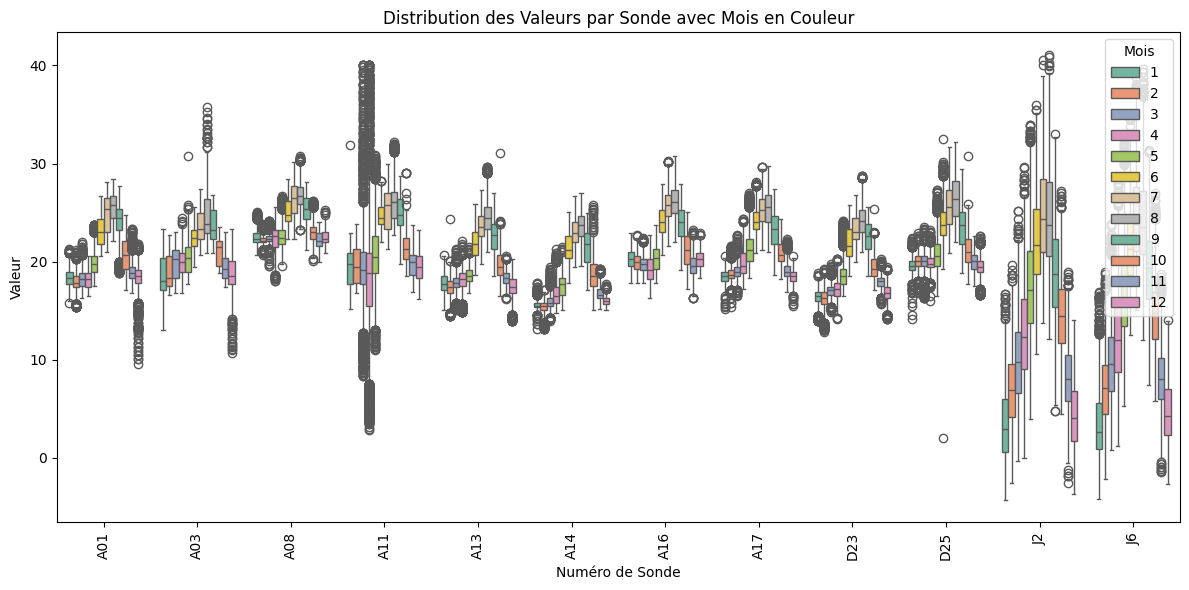

In [40]:

# Créer un box plot avec des couleurs basées sur le mois
plt.figure(figsize=(12, 6))
sns.boxplot(x='Numéro', y='Valeur', data=AIH, hue='Mois', palette='Set2')

# Ajouter un titre et des labels
plt.title('Distribution des Valeurs par Sonde avec Mois en Couleur')
plt.xlabel('Numéro de Sonde')
plt.ylabel('Valeur')

# Afficher le graphique avec les légendes
plt.legend(title='Mois', loc='upper right')

# Afficher le graphique
plt.xticks(rotation=90)  # Faire pivoter les étiquettes des sondes si nécessaire
plt.tight_layout()  # Pour ajuster les éléments du graphique
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


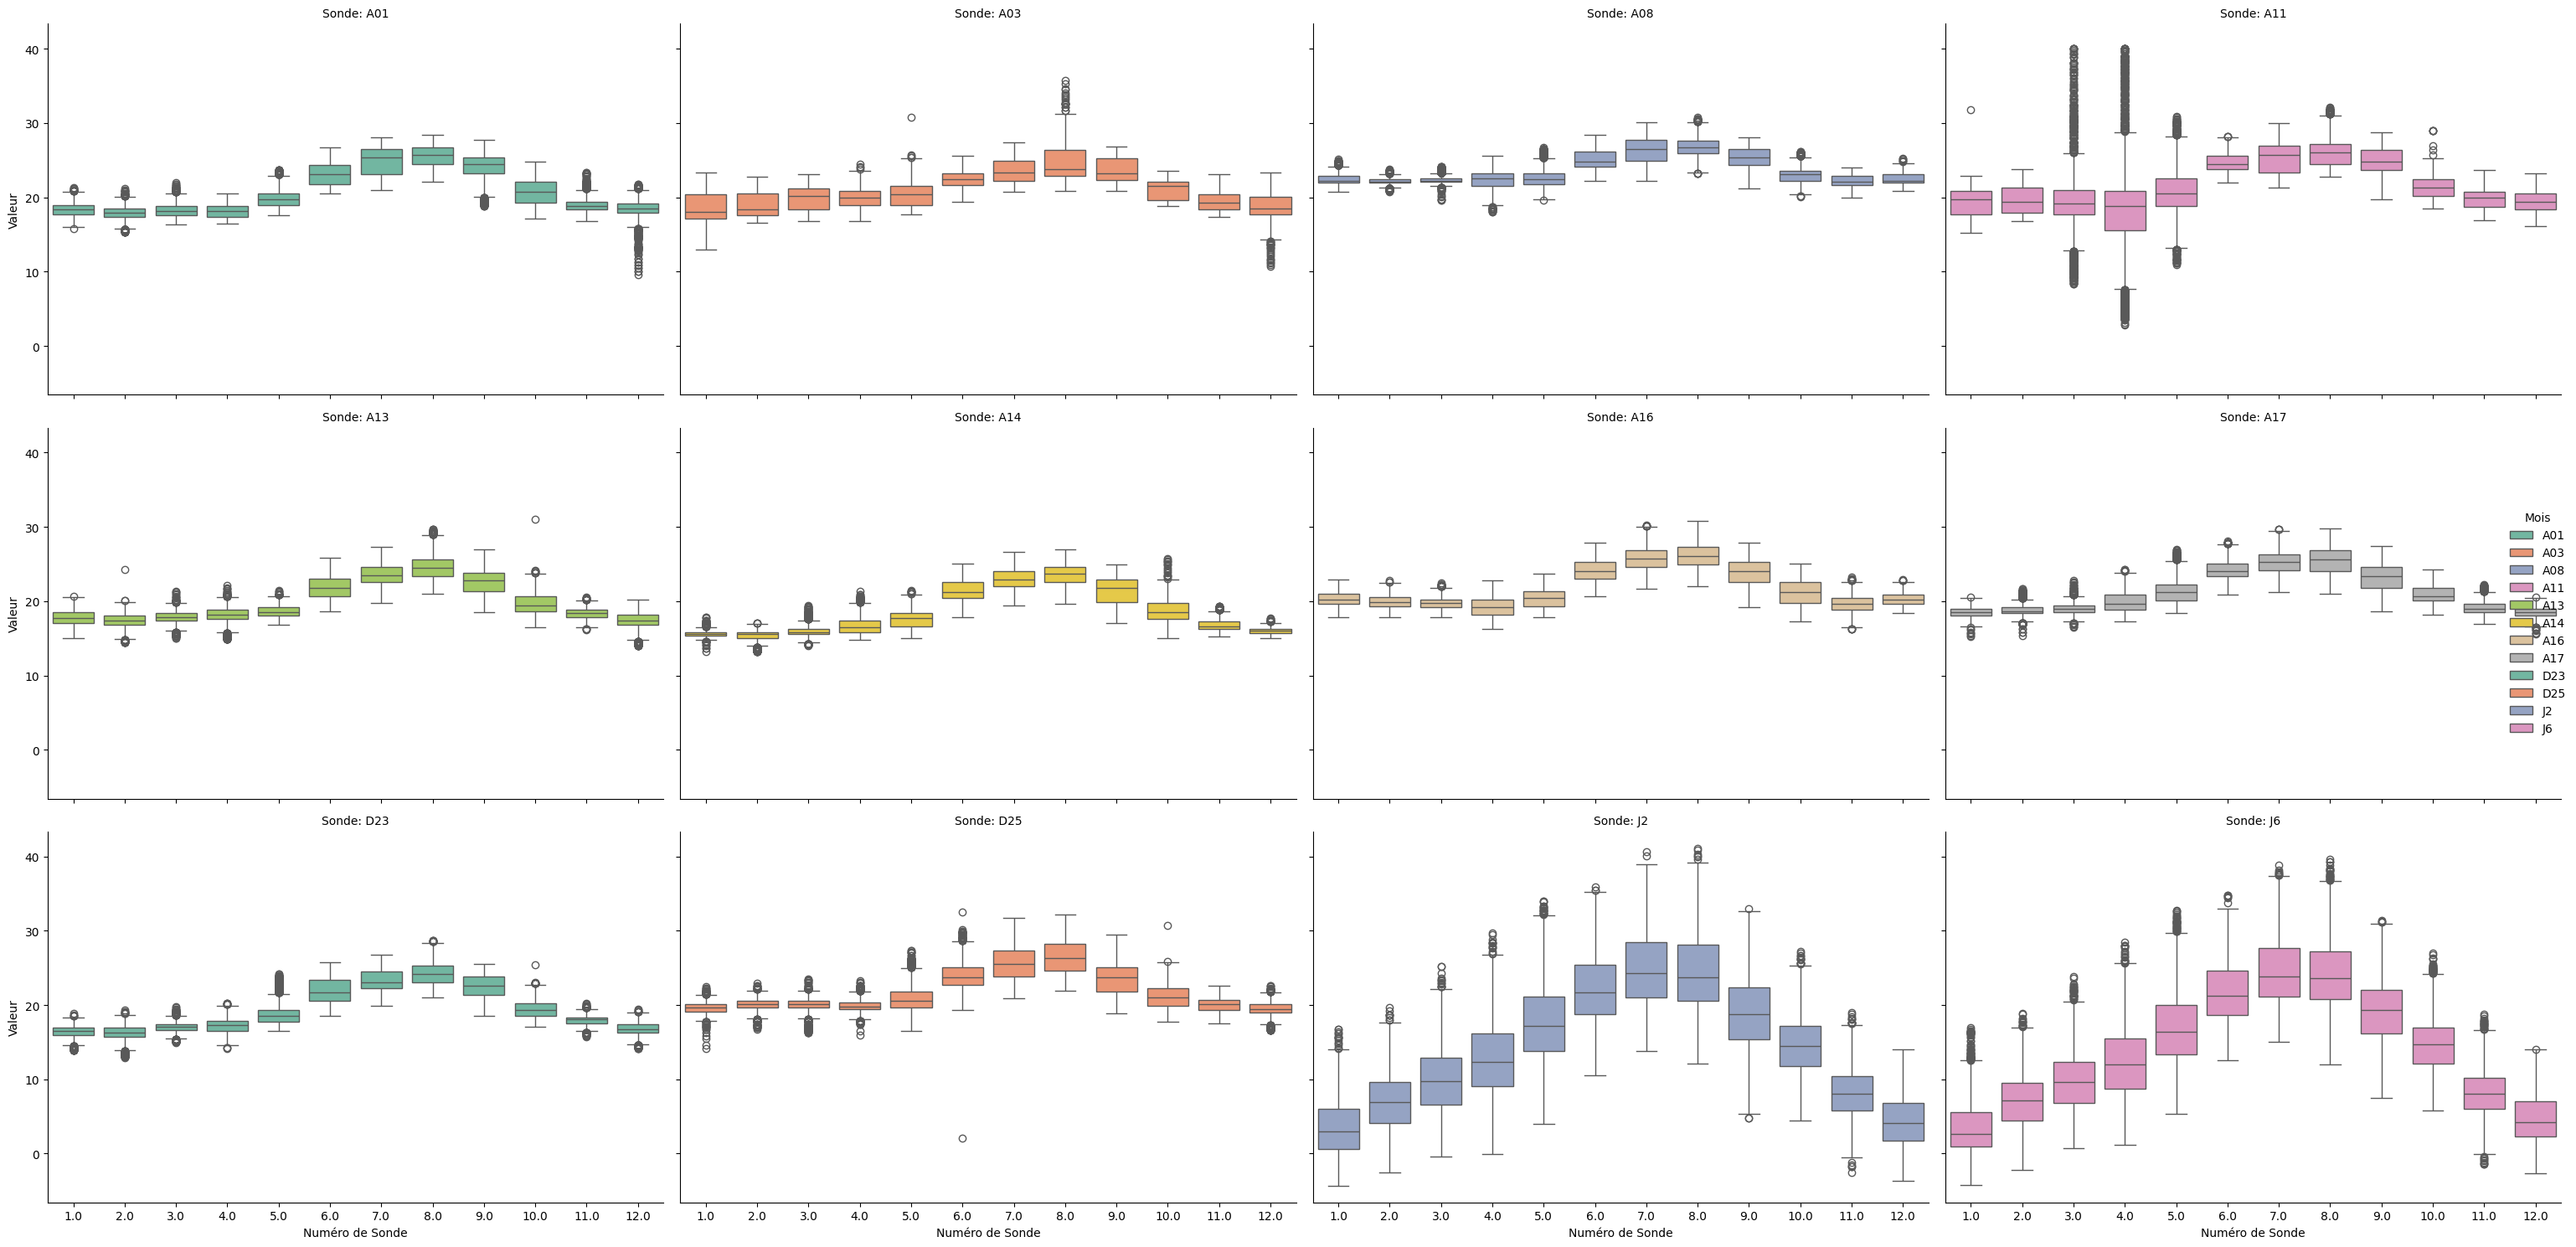

In [41]:
# Créer une grille de facettes pour chaque sonde
g = sns.FacetGrid(AIH, col='Numéro', col_wrap=4, height=5, aspect=1.5)

# Ajouter un boxplot à chaque facette en utilisant 'AIH' comme data
g.map(sns.boxplot, 'Mois', 'Valeur', hue='Numéro', palette='Set2', data=AIH)

# Ajouter les légendes, titres et ajuster
g.set_axis_labels('Numéro de Sonde', 'Valeur')
g.set_titles('Sonde: {col_name}')
g.add_legend(title='Mois')

# Afficher le graphique
plt.tight_layout()  # Pour ajuster l'espacement des sous-graphiques
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


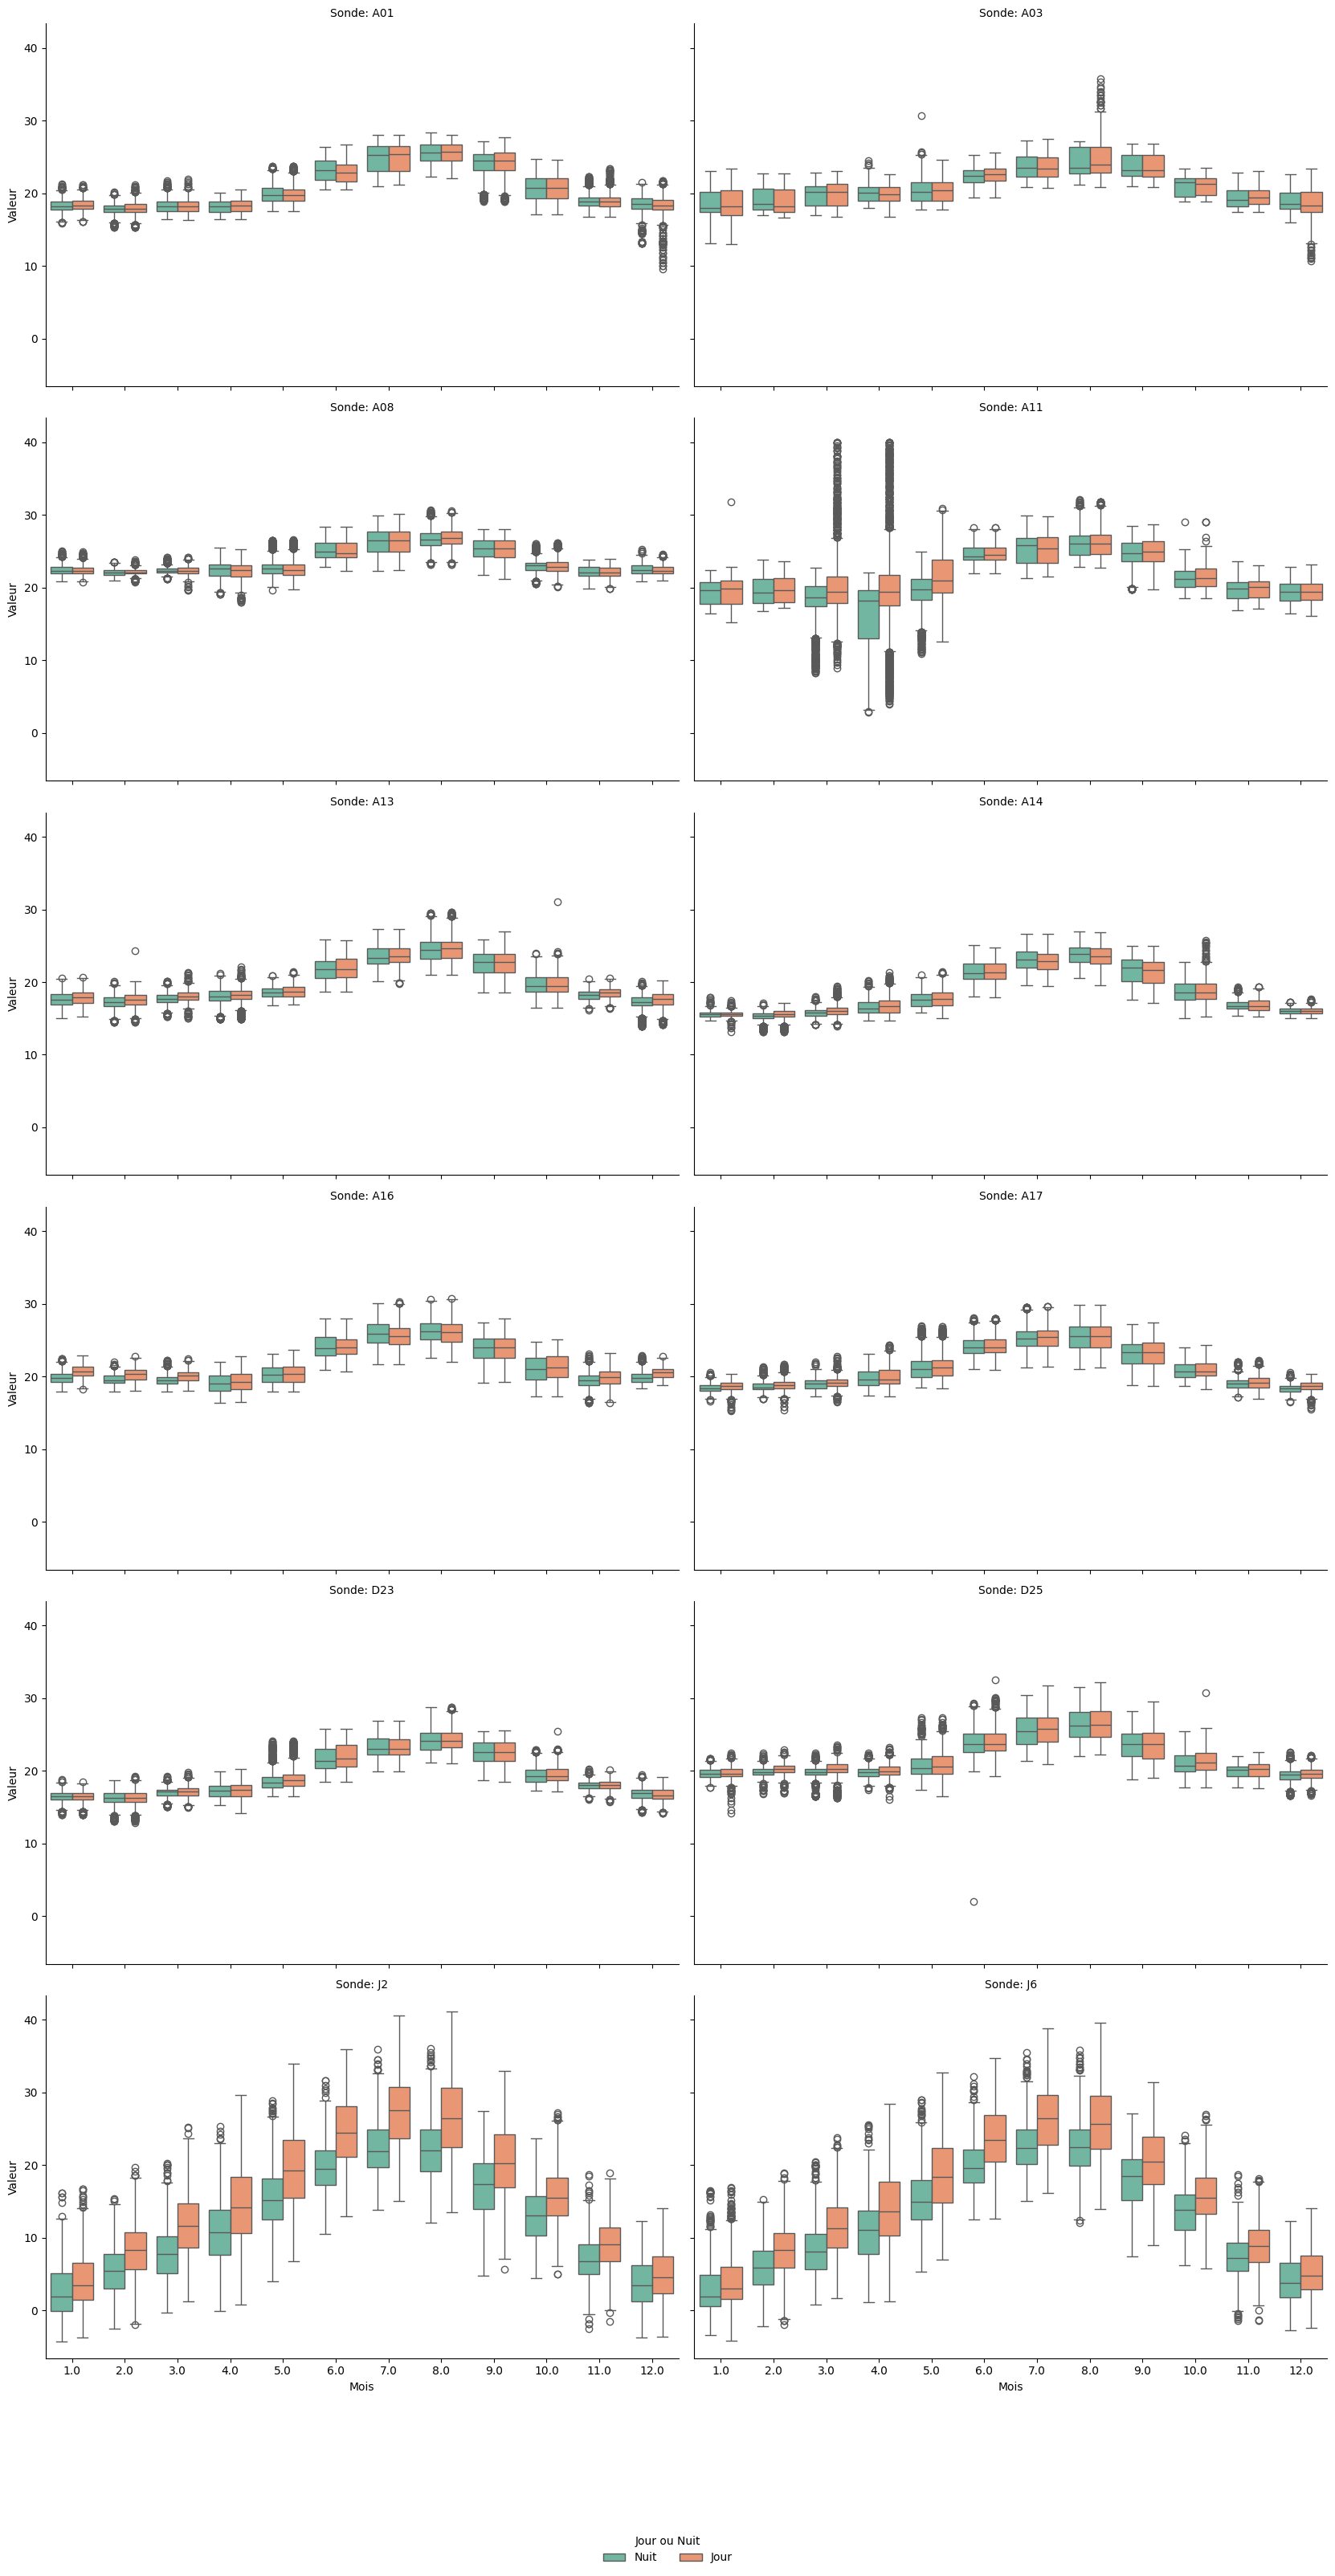

In [57]:
# Créer une grille de facettes pour chaque sonde
g = sns.FacetGrid(AIH, col='Numéro', col_wrap=2, height=5, aspect=1.5)

# Ajouter un boxplot à chaque facette, différencié par 'Jour/Nuit'
g.map(
    sns.boxplot,
    'Mois',  # Axe x : Mois
    'Valeur',  # Axe y : Température
    hue='Jour/Nuit',  # Différenciation par Jour/Nuit
    palette='Set2',  # Palette de couleurs
    data=AIH
)

# Ajouter des légendes, titres et ajuster
g.set_axis_labels('Mois', 'Valeur')
g.set_titles('Sonde: {col_name}')
g.add_legend(title='Jour ou Nuit', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3)

# Ajuster l'espacement des facettes
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


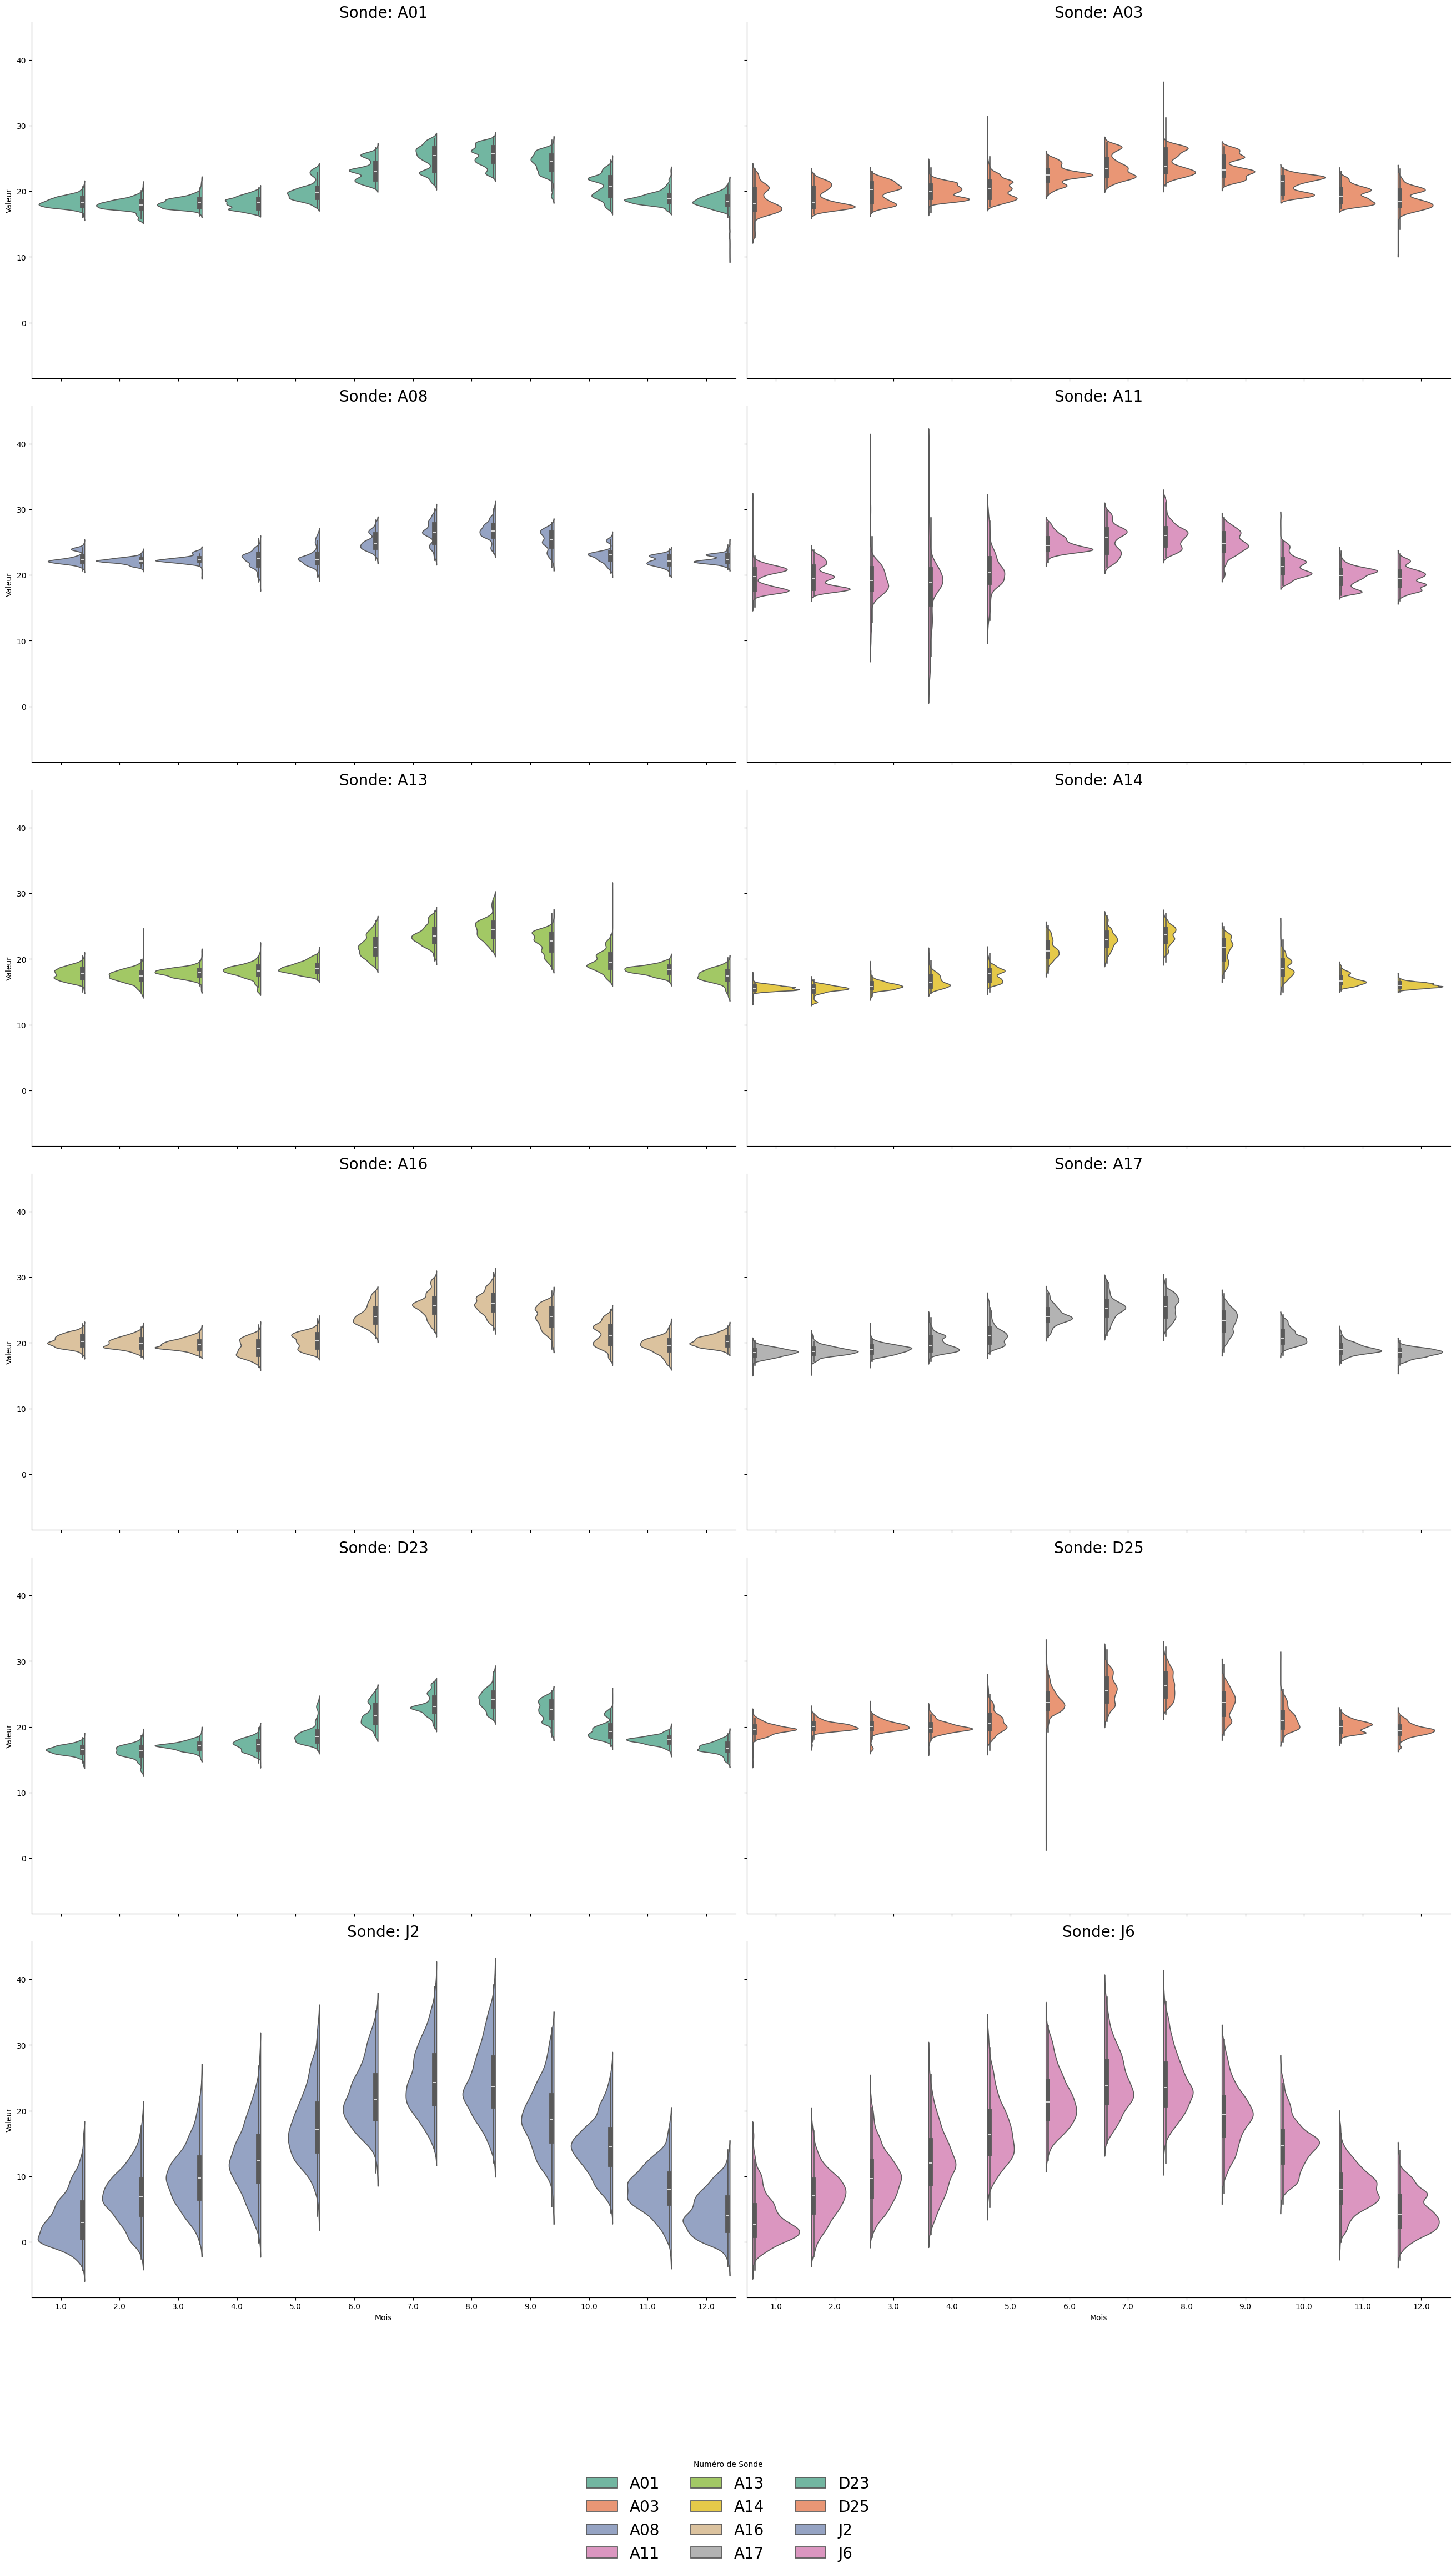

In [42]:
# Créer une grille de facettes pour chaque sonde
g = sns.FacetGrid(AIH, col='Numéro', col_wrap=2, height=7, aspect=1.5)

# Ajouter un violin plot à chaque facette en utilisant 'AIH' comme data
g.map(sns.violinplot, 'Mois', 'Valeur', hue='Numéro', palette='Set2', data=AIH, split=True)

# Ajouter les légendes et ajuster
g.set_axis_labels('Mois', 'Valeur')
g.set_titles('Sonde: {col_name}', size=20)
g.add_legend(
    title='Numéro de Sonde',
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    ncol=3,
    prop={'size': 20}  # Taille de la légende
)

# Afficher le graphique
plt.tight_layout()  # Pour ajuster l'espacement des sous-graphiques
plt.show()

In [48]:

# Filtrer les données pour exclure les sondes J2 et J6
AIH_Int = AIH[~AIH['Type'].isin([ 'Sonde Intérieur'])]

# Vérifier que la colonne 'Date' est bien en format datetime
AIH_Int['Date'] = pd.to_datetime(AIH_Int['Date'])

# Calculer le jour de la semaine (1 = lundi, 7 = dimanche)
AIH_Int['Jour'] = AIH_Int['Date'].dt.isocalendar().day

# Regrouper les données par jour et calculer la moyenne et l'écart-type
AIH_Int_grouped = AIH_Int.groupby(['Jour']).agg(
    moyenne_temp=('Valeur', 'mean'),
    std_temp=('Valeur', 'std')
).reset_index()

# Tracer le graphique
plt.figure(figsize=(10, 6))
for annee in AIH_Int_grouped['annee'].unique():
    data = AIH_filtered_grouped[AIH_Int_grouped['annee'] == annee]
    plt.errorbar(data['Jour'], data['moyenne_temp'], yerr=data['std_temp'], label=annee, capsize=3)

# Ajouter des labels et une légende
plt.title('Température Moyenne par jour pour les Sondes Extérieurs')
plt.xlabel('Jour')
plt.ylabel('Température (°C)')
plt.legend(title='Numéro de Sonde', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


<ipython-input-48-e005437216c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIH_Int['Date'] = pd.to_datetime(AIH_Int['Date'])
<ipython-input-48-e005437216c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIH_Int['Jour'] = AIH_Int['Date'].dt.isocalendar().day


KeyError: 'annee'

<Figure size 1000x600 with 0 Axes>

<ipython-input-47-977d1bb98817>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIH_Int['Jour'] = AIH_Int['Date'].dt.dayofyear


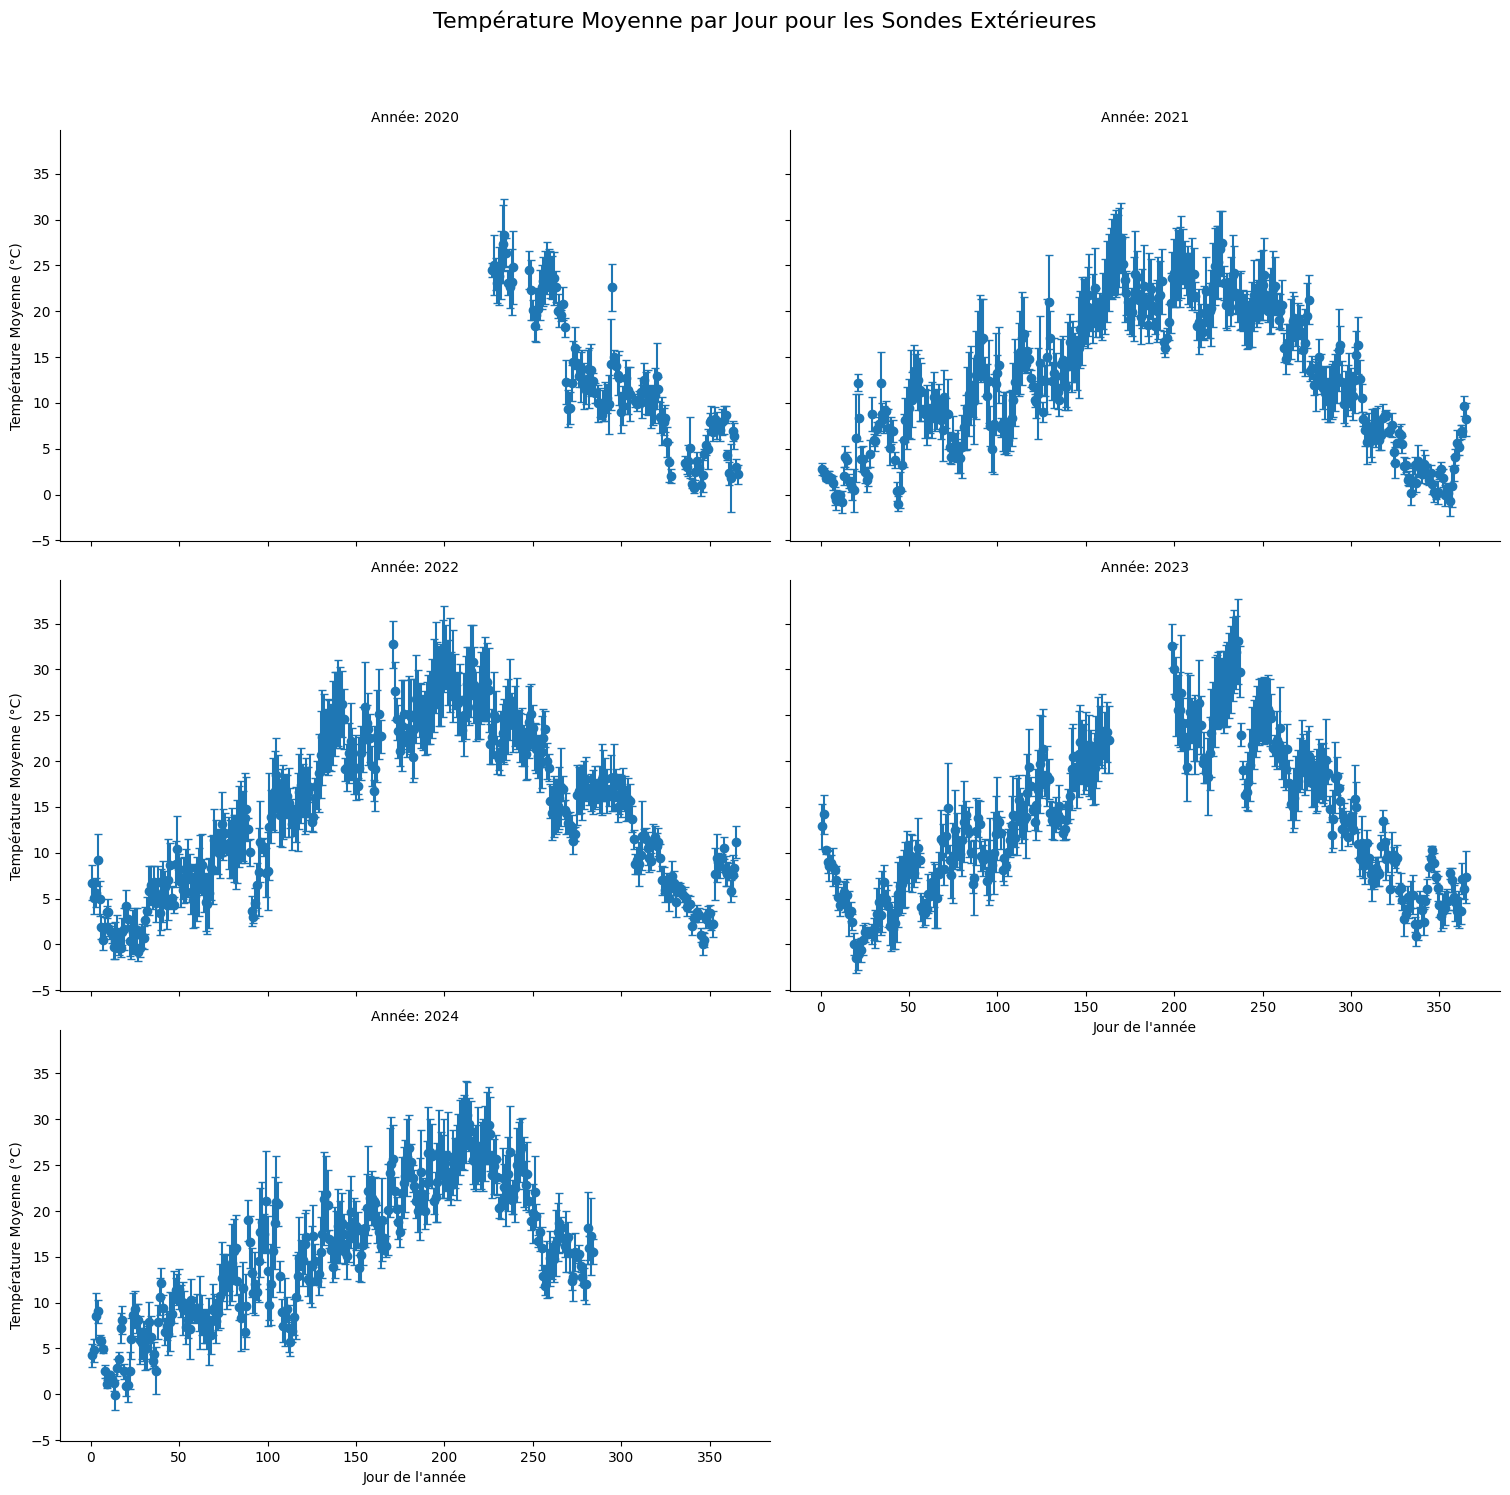

In [47]:

# Filtrer les données pour exclure les sondes Intérieures
AIH_Int = AIH[AIH['Type'] != 'Sonde Intérieur']

# Ajouter une colonne 'Jour' correspondant au jour de l'année
AIH_Int['Jour'] = AIH_Int['Date'].dt.dayofyear

# Calculer la moyenne et l'écart-type par jour et par année
AIH_Int_grouped = AIH_Int.groupby(['Jour', 'annee']).agg(
    moyenne_temp=('Valeur', 'mean'),
    std_temp=('Valeur', 'std')
).reset_index()

# Créer une grille de facettes pour chaque année
g = sns.FacetGrid(AIH_Int_grouped, col="annee", col_wrap=2, height=5, aspect=1.5)

# Ajouter des points et des barres d'erreur pour chaque facette
def plot_with_error(data, **kwargs):
    plt.errorbar(data['Jour'], data['moyenne_temp'], yerr=data['std_temp'], fmt='o', capsize=3, **kwargs)

g.map_dataframe(plot_with_error)

# Ajouter des titres, axes et légendes
g.set_axis_labels('Jour de l\'année', 'Température Moyenne (°C)')
g.set_titles('Année: {col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Température Moyenne par Jour pour les Sondes Extérieures", fontsize=16)

# Afficher le graphique
plt.show()


In [71]:
# Filtrer les données pour "Sonde Intérieur"
AIH_interieur = AIH[AIH['Type'] == 'Sonde Intérieur']

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect

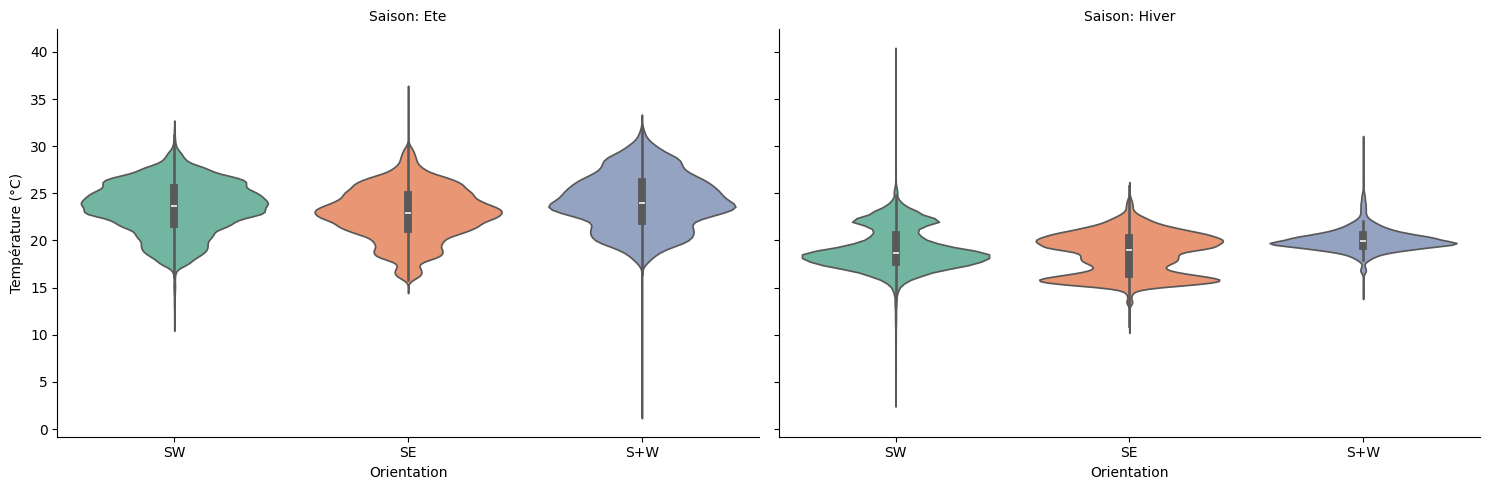

In [89]:
# Créer une grille de facettes pour les saisons (Été/Hiver)
g = sns.FacetGrid(AIH_interieur, col='Ete/Hiver', height=5, aspect=1.5)

# Ajouter des violins plots pour chaque orientation
g.map_dataframe(
    sns.violinplot,
    x='Orientation',
    y='Valeur',
    palette='Set2',
    scale='width'
)

# Ajuster les légendes et les axes
g.set_axis_labels('Orientation', 'Température (°C)')
g.set_titles('Saison: {col_name}')


# Améliorer la présentation
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect

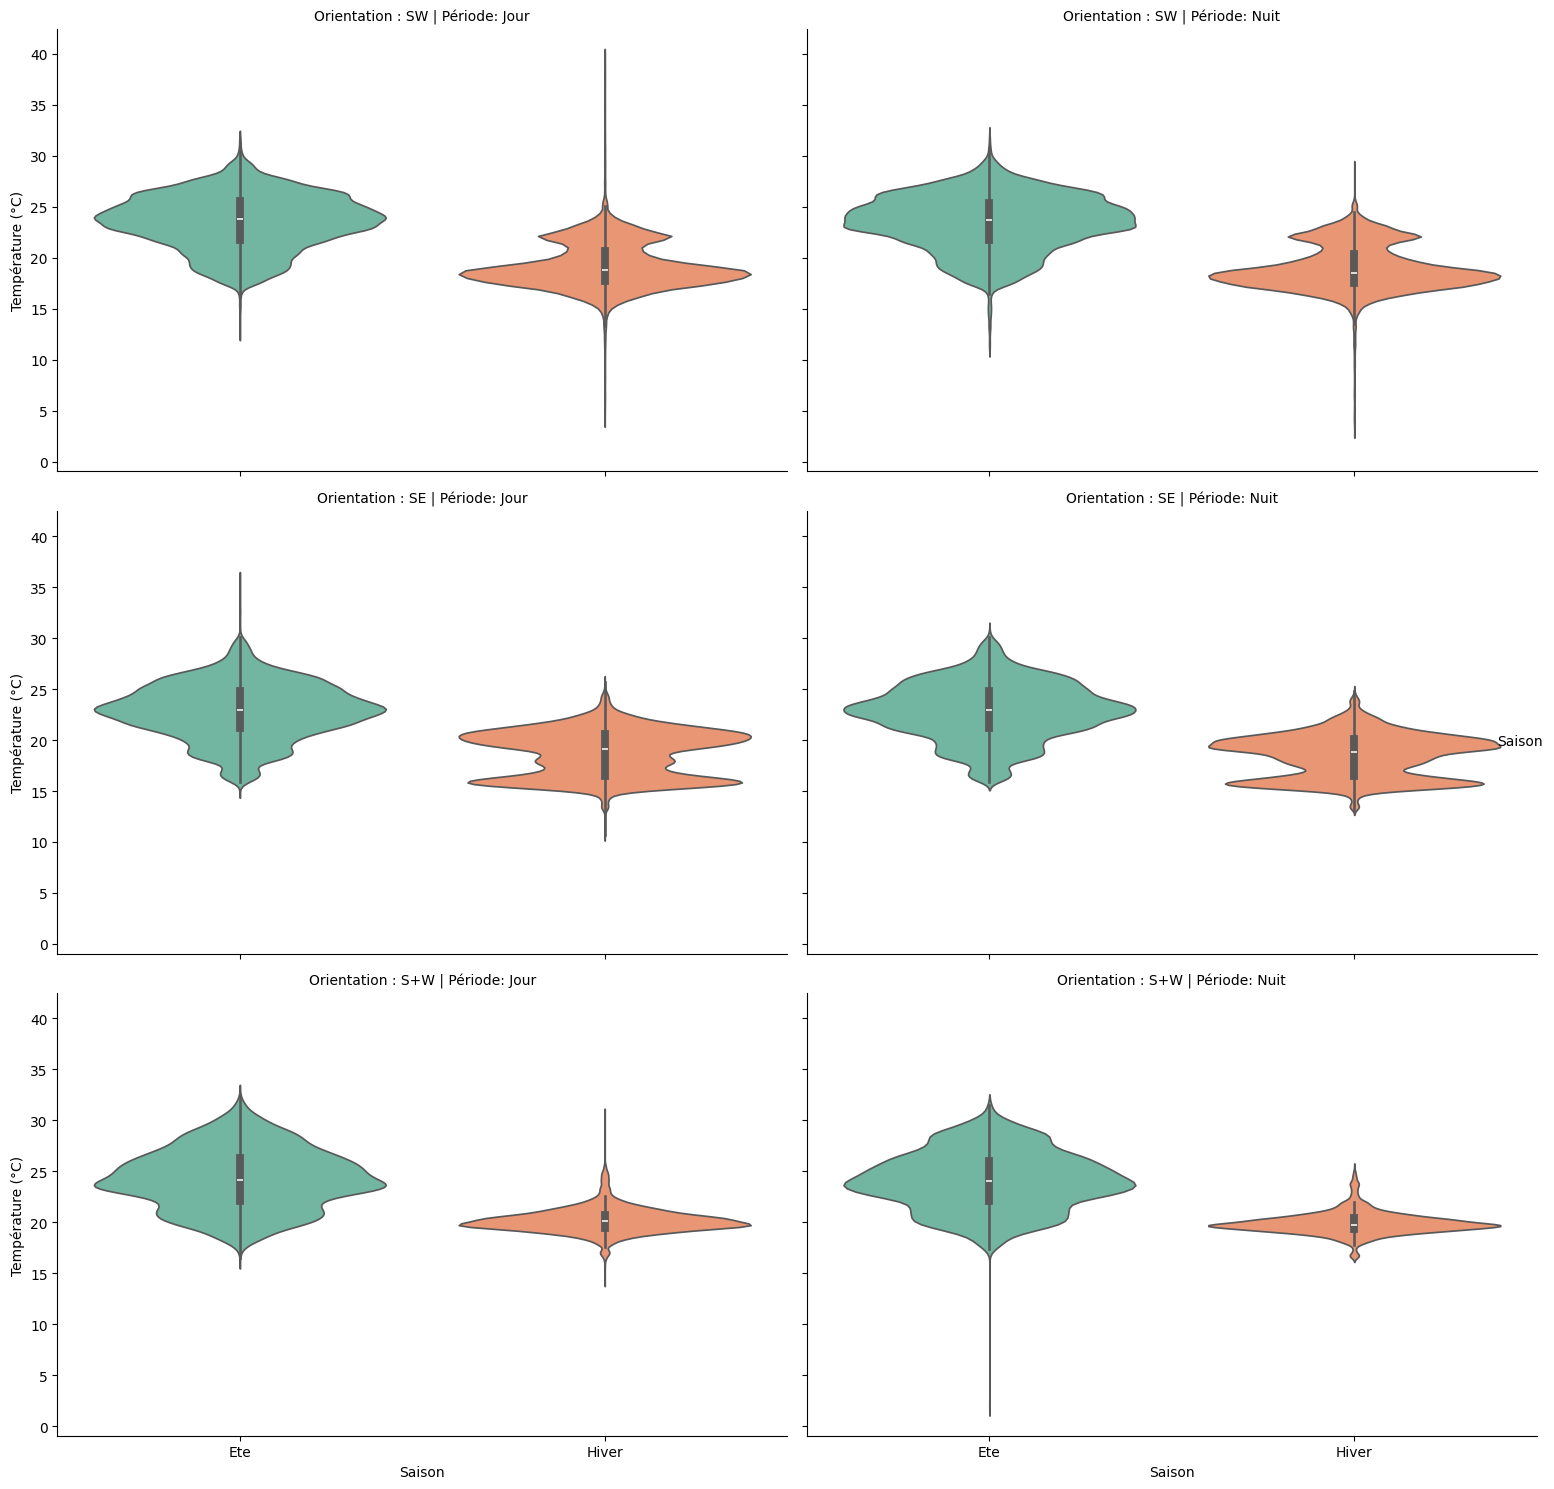

In [88]:

# Créer une grille de facettes avec "Ete/Hiver" et "Jour/Nuit"
g = sns.FacetGrid(
    AIH_interieur,
    row='Orientation',
    col='Jour/Nuit',
    height=5,
    aspect=1.5
)

# Ajouter des violins plots pour chaque orientation
g.map_dataframe(
    sns.violinplot,
    x='Ete/Hiver',
    y='Valeur',
    palette='Set2',
    scale='width'
)

# Ajuster les axes, titres et légendes
g.set_axis_labels('Saison', 'Température (°C)')
g.set_titles(row_template='Orientation : {row_name}', col_template='Période: {col_name}')
g.add_legend(title='Saison')

# Améliorer l'apparence
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect

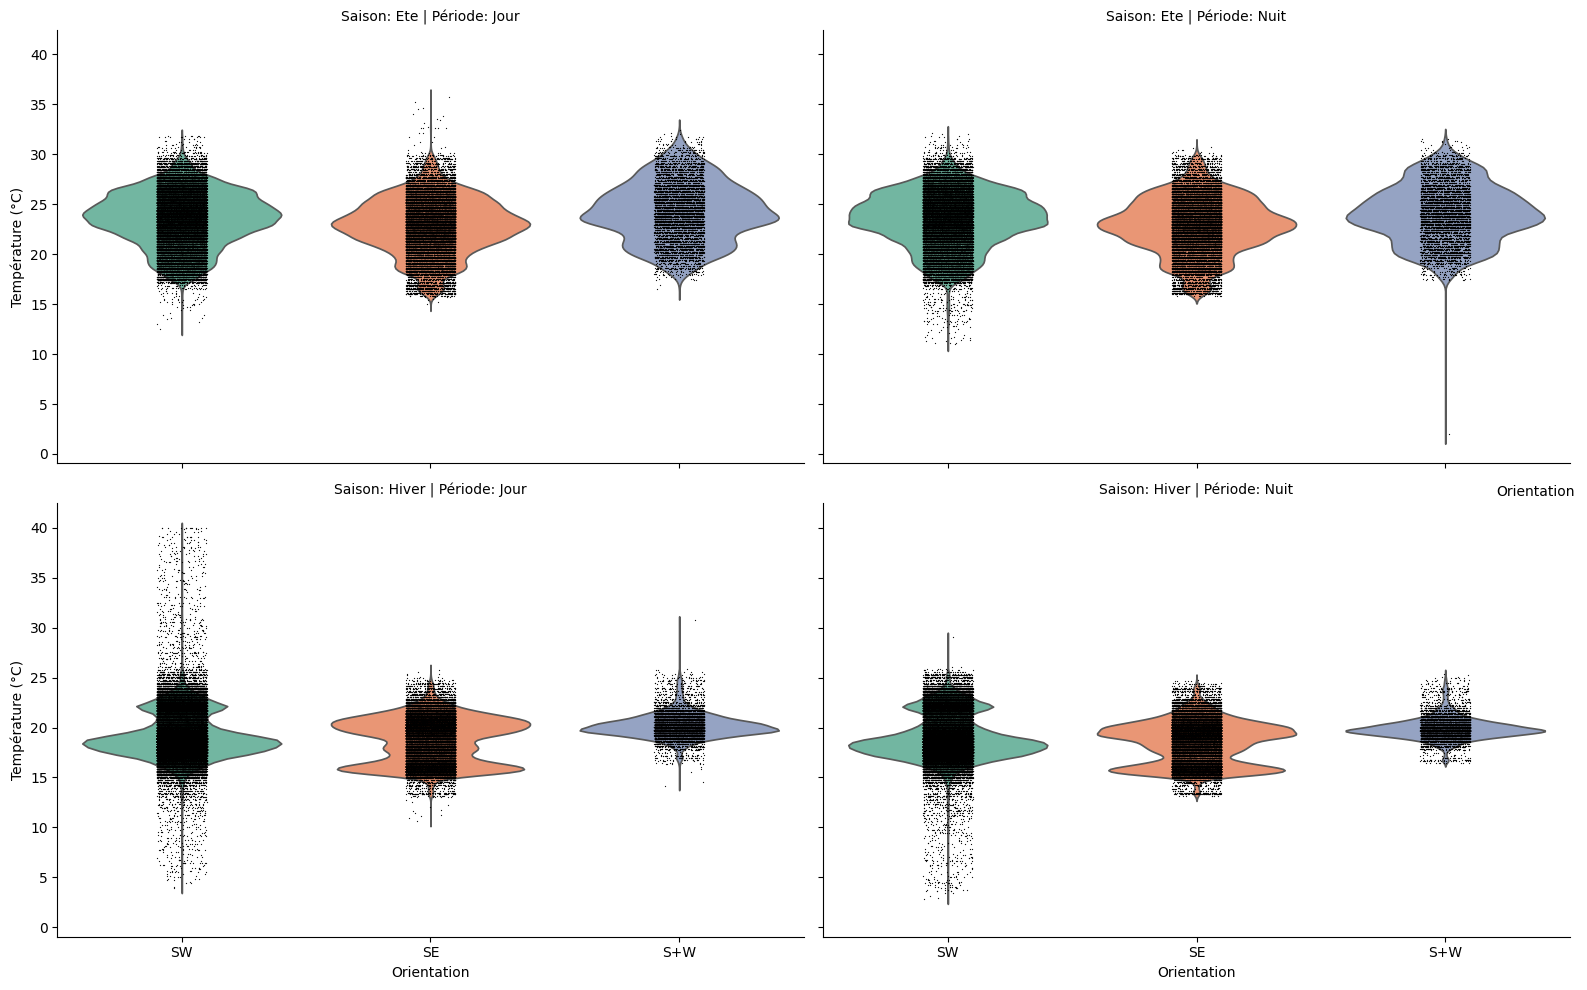

In [84]:
# Créer une grille de facettes avec "Ete/Hiver" et "Jour/Nuit"
g = sns.FacetGrid(
    AIH_interieur, # sous tableau avec que les sondes intérieures.
    row='Ete/Hiver',
    col='Jour/Nuit',
    height=5,
    aspect=1.5
)

# Ajouter des violins plots avec les outliers représentés par des points
g.map_dataframe(
    sns.violinplot,
    x='Orientation',
    y='Valeur',
    palette='Set2',
    scale='width',
    inner=None  # Supprimer la représentation par défaut des données internes
)

# Superposer les points pour représenter les outliers avec des ronds vides noirs et de taille plus petite
g.map_dataframe(
    sns.stripplot,
    x='Orientation',
    y='Valeur',
    color='k',  # Points noirs
    marker='o',  # Forme du point : rond
    size= 0.9,  # Taille réduite des points
    alpha=0.95,  # Transparence des points
    jitter=True )  # Ajouter un léger écartement pour améliorer la lisibilité


# Ajuster les axes, titres et légendes
g.set_axis_labels('Orientation', 'Température (°C)')
g.set_titles(row_template='Saison: {row_name}', col_template='Période: {col_name}')
g.add_legend(title='Orientation')

# Améliorer l'apparence
plt.tight_layout()
plt.show()
